# Extracting enriched function modules from a given study

We have checked that for this particular condition our analysis seems to be really consistent and not affected by the cutoff value of the GIMME method. But for extracting new insights and patterns from a whole study we need to apply this method across all experimental conditions tested.

In [1]:
import os
import cobra
from cobra.flux_analysis import flux_variability_analysis
import reframed
from reframed import load_cbmodel, from_cobrapy
from reframed.cobra.transcriptomics import gene_to_reaction_expression
import gurobipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools.designFunctions import *
from numpy import percentile
import plotly.express as px
#For constructing the ica object:
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model

### 1.Load expression data and the GEM

In [4]:
species = 'escherichia_coli'
study_name = 'ICA_Study'
metadata_filepath = '/'.join(['data',species,'sample_table.csv'])
expression_filepath = '/'.join(['data',species,'log_tpm.csv'])
metadata = pd.read_csv(metadata_filepath)
expression_data = pd.read_csv(expression_filepath).set_index('Geneid')
    
#Study_dict has a pattern of:
#            { <media_name>-{<carbon_source.key>:<carbon_source.value>}*nº of sources : <replicate ids list> }
study_dict = {'m9-EX_glc__D_e:10.0': [ 'ecoli_00169',
                                      'ecoli_00170',
                                      'ecoli_00171',
                                      'ecoli_00172',
                                      'ecoli_00193',
                                      'ecoli_00194'],
             'm9-EX_glc__D_e:10.0-EX_o2_e:0.0': ['ecoli_00183',    #anaerobic condition (KNO3 as e- acceptor)
                                                 'ecoli_00184'],    #anaerobic condition (KNO3 as e- acceptor)
             'm9-EX_glc__D_e:10.0-EX_gthrd_e:16.67': ['ecoli_00177',
                                                      'ecoli_00178'],
             'm9-EX_glc__D_e:10.0-EX_met__L_e:8.33': ['ecoli_00181',
                                                      'ecoli_00182'],
             'm9-EX_glc__D_e:10.0-EX_ade_e:8.33': ['ecoli_00197',
                                                   'ecoli_00198'],
             'm9-EX_sbt__D_e:10.0-EX_arg__L_e:10.0': ['ecoli_00173',
                                                      'ecoli_00174'],
             'm9-EX_rib__D_e:8.33-EX_cytd_e:15.0': ['ecoli_00175',
                                                    'ecoli_00176'],
             'm9-EX_glcr_e:10.0-EX_leu__L_e:10.0': ['ecoli_00179',
                                                    'ecoli_00180'],
             'm9-EX_acgam_e:13.33-EX_phe__L_e:15.0': ['ecoli_00185',
                                                      'ecoli_00186'],
             'm9-EX_gal_e:10.0-EX_thm_e:20.0': ['ecoli_00187',
                                                'ecoli_00188'],
             'm9-EX_glcn_e:10.0-EX_tyr__L_e:15.0': ['ecoli_00189',
                                                    'ecoli_00190'],
             'm9-EX_pyr_e:5.0-EX_ura_e:6.67': ['ecoli_00191',
                                               'ecoli_00192']}

#Load the model
model_name = 'iML1515.xml'
model_filepath = '/'.join(['models', model_name])
cobra_model = cobra.io.read_sbml_model(model_filepath)
cobra_model = reformat_bounds(cobra_model)

Read LP format model from file /tmp/tmpjv84_eq4.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [5]:
#Create directories for saving the results
results_dir = '/'.join(['results', species])
study_results_dir = '/'.join([results_dir, study_name])
figure_results_dir = '/'.join([results_dir, study_name, 'Figures'])

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
 
if not os.path.exists(study_results_dir):
    os.mkdir(study_results_dir)
    os.mkdir(figure_results_dir)

### 2.Construct the ICA object

#### 2.1 Load expression data and the GEM Load iModulon table to translate columns anD rows in M and A tables respectively:

In [6]:
im_table_filepath = '/'.join(['data',species,'iM_table.csv'])
im_table = pd.read_csv(im_table_filepath)
im_dict = {str(row.k) : row.name for row in im_table[['k','name']].itertuples() }
im_table.set_index('name', inplace=True)
im_table

k regulator_readable  function               category  n_genes  \
name                                                                            
e14 Removal    0                NaN       NaN               Prophage       13   
SG_yzfA        1                NaN       NaN                Unknown        3   
SG_ytiD        2                NaN       NaN                Unknown        1   
Membrane-1     3                NaN       NaN   Membrane Homeostasis       81   
CysB-1         4               CysB       NaN  Amino Acid Metabolism       31   
...          ...                ...       ...                    ...      ...   
SG_ybfQ      213                NaN       NaN                Unknown        4   
SG_ynaM      214                NaN       NaN                Unknown        2   
GlpR-2       215               GlpR       NaN      Carbon Metabolism        6   
PdeL         216                NaN       NaN                Unknown        6   
SG_sgrT      217                NaN       NaN                Unknown        2   

              exp_var  precision    recall  category_num  
name                                                      
e14 Removal  0.003487        NaN       NaN            21  
SG_yzfA      0.000530        NaN       NaN            24  
SG_ytiD      0.000471        NaN       NaN            24  
Membrane-1   0.009719        NaN       NaN            11  
CysB-1       0.009645   0.225806  0.411765             2  
...               ...        ...       ...           ...  
SG_ybfQ      0.000509        NaN       NaN            24  
SG_ynaM      0.002158        NaN       NaN            24  
GlpR-2       0.000723   0.833333  0.555556             0  
PdeL         0.000768        NaN       NaN            24  
SG_sgrT      0.000652        NaN       NaN            24  

[218 rows x 9 columns]

#### 2.2 Construct the basic ICA object

In [7]:
M_table_filepath = '/'.join(['data',species,'M.csv'])
M = pd.read_csv(M_table_filepath)
im_dict['Unnamed: 0'] = 'gen'
M.rename(columns =im_dict, inplace = True)
M.set_index('gen', inplace=True)
M

e14 Removal   SG_yzfA   SG_ytiD  Membrane-1    CysB-1  CueR/CusR/HprR  \
gen                                                                            
b0002    -0.000358 -0.008590  0.003601   -0.012687  0.005562       -0.008805   
b0003    -0.010837  0.001999  0.011521    0.002356  0.005713       -0.004448   
b0004    -0.011196  0.010332  0.010215    0.008323  0.002182       -0.004335   
b0005     0.001831  0.008297 -0.006886    0.008113 -0.000454        0.004255   
b0006     0.009458 -0.002019  0.015016   -0.005517 -0.004051       -0.000016   
...            ...       ...       ...         ...       ...             ...   
b4399    -0.005435 -0.000862 -0.001009    0.002962 -0.002097       -0.003631   
b4400    -0.003509  0.007552  0.014341   -0.006045 -0.000268        0.000341   
b4401    -0.003444  0.007116  0.001074    0.004715 -0.012893        0.000782   
b4402    -0.016195  0.061764 -0.014592   -0.003999 -0.000413        0.004475   
b4403    -0.011528 -0.005571  0.005006    0.000253 -0.004747       -0.000671   

          DLP12   SG_yqhI   SG_icdC   NQ-ALE3  ...   SG_cspH   SG_ymcE  \
gen                                            ...                       
b0002  0.001628 -0.002981 -0.005618  0.002741  ...  0.007893  0.007961   
b0003 -0.006117  0.014313  0.006507 -0.001974  ... -0.011125 -0.002493   
b0004 -0.001893  0.002386  0.008030  0.002420  ... -0.006413 -0.000588   
b0005  0.031781 -0.000679  0.005952  0.011142  ... -0.011150  0.009998   
b0006  0.002706  0.005039  0.007791 -0.008338  ... -0.002731  0.002148   
...         ...       ...       ...       ...  ...       ...       ...   
b4399 -0.000578  0.000235 -0.002511  0.005352  ... -0.014640  0.005406   
b4400  0.010566  0.012339  0.003326  0.023681  ...  0.007242  0.026212   
b4401 -0.012861 -0.021927 -0.010887  0.001683  ...  0.002610 -0.003137   
b4402 -0.012897  0.036598  0.003351  0.016852  ...  0.008835  0.007436   
b4403 -0.014258 -0.006051 -0.003435 -0.002522  ... -0.004506  0.001554   

           OmpR      NarL  NtrC+RpoS   SG_ybfQ   SG_ynaM    GlpR-2      PdeL  \
gen                                                                            
b0002  0.006694 -0.007216  -0.012779  0.009632  0.000493  0.000036 -0.021155   
b0003  0.020232  0.015658  -0.004292  0.004611  0.017251 -0.008580  0.008200   
b0004  0.015639  0.012891  -0.000049  0.008568  0.012664 -0.007649  0.014636   
b0005 -0.003796  0.023029  -0.008983 -0.002186 -0.008396 -0.003082  0.001796   
b0006  0.010465  0.007808   0.002363  0.007910 -0.000523  0.002802  0.011354   
...         ...       ...        ...       ...       ...       ...       ...   
b4399 -0.005309 -0.007466  -0.002523  0.007945 -0.000425  0.003699  0.014430   
b4400 -0.010677  0.011861  -0.010043 -0.011006 -0.009490 -0.011233  0.020347   
b4401  0.000657  0.005381   0.028456  0.000641 -0.005313  0.012298 -0.006008   
b4402  0.004202 -0.001710   0.015668 -0.031288 -0.003017  0.013990  0.004978   
b4403 -0.004069  0.016058   0.011239  0.011375 -0.012363  0.006549  0.000667   

        SG_sgrT  
gen              
b0002 -0.011153  
b0003 -0.001142  
b0004 -0.008665  
b0005 -0.007888  
b0006 -0.002649  
...         ...  
b4399 -0.001713  
b4400  0.005650  
b4401  0.011715  
b4402  0.012152  
b4403  0.013491  

[4211 rows x 218 columns]

In [8]:
A_table_filepath = '/'.join(['data',species,'A.csv'])
A = pd.read_csv(A_table_filepath)
A.rename(columns = {'Unnamed: 0':'iModulon'}, inplace = True)
A.iModulon = [im_dict[str(k)] for k in A.iModulon.values.tolist()]
A.set_index('iModulon', inplace=True)
ica_data = IcaData(M,A)
A

ecoli_00001  ecoli_00002  ecoli_00003  ecoli_00004  ecoli_00005  \
e14 Removal    -0.128304     0.128304    -1.531027    -1.963977    -0.303246   
SG_yzfA        -0.152539     0.152539    -2.741850    -1.200373    -1.446482   
SG_ytiD         0.249185    -0.249185     3.262396     3.948667     0.843348   
Membrane-1     -0.104403     0.104403    -4.916100    -5.861405     1.058649   
CysB-1         -0.176603     0.176603     3.582368     4.747595     2.041670   
...                  ...          ...          ...          ...          ...   
SG_ybfQ         0.252765    -0.252765    -3.197852    -2.348775    -0.730892   
SG_ynaM        -0.806208     0.806208    -0.236285     2.470518     0.704412   
GlpR-2         -0.374599     0.374599     0.113874     0.020002    -0.130984   
PdeL            0.095403    -0.095403    -0.208565    -0.049936     0.123347   
SG_sgrT        -0.140032     0.140032     1.386072     1.416696     1.812881   

             ecoli_00006  ecoli_00007  ecoli_00008  ecoli_00009  ecoli_00010  \
e14 Removal    -0.062866    -1.375827    -1.600358    -0.164066    -0.281141   
SG_yzfA        -1.101239    -1.340625    -0.672756    -0.524996    -0.650100   
SG_ytiD         0.983687     2.730156     2.949588     2.111970     2.283055   
Membrane-1      1.005977    -3.312421    -3.625048     1.257151     1.107445   
CysB-1          1.917720     2.480352     3.153594     2.702293     2.850132   
...                  ...          ...          ...          ...          ...   
SG_ybfQ         0.209796    -2.265536    -1.327736    -2.047324    -1.620692   
SG_ynaM        -0.083709     1.204765     3.597766     0.690591     0.239457   
GlpR-2         -0.361774     0.007051     0.211294    -0.772821    -0.533565   
PdeL            0.015959    -0.323685    -0.192190     0.406844     1.019091   
SG_sgrT         2.082324     2.014359     1.983151     1.852860     1.920822   

             ...  ecoli_00836  ecoli_00837  ecoli_00838  ecoli_00839  \
e14 Removal  ...     1.603103     2.218117     2.299468     2.110294   
SG_yzfA      ...    -0.904385    -1.173453    -1.248829    -1.370640   
SG_ytiD      ...    -0.191715     1.451728     1.210193     1.315993   
Membrane-1   ...     1.834209     1.838009     3.781963     3.501219   
CysB-1       ...     1.169348     0.965257     0.153500     0.925511   
...          ...          ...          ...          ...          ...   
SG_ybfQ      ...     1.366825     1.086655     1.157643     1.151417   
SG_ynaM      ...    -1.526969    -0.986787    -1.227507    -0.962135   
GlpR-2       ...     0.148360     0.389226     0.229326     0.535328   
PdeL         ...     0.245031     0.236841     0.854063     1.107624   
SG_sgrT      ...     1.630191     2.039039     3.232556     2.215267   

             ecoli_00840  ecoli_00841  ecoli_00842  ecoli_00843  ecoli_00844  \
e14 Removal     2.100683     2.582940     2.064856     2.209638     1.913363   
SG_yzfA        -0.901145    -0.604680    -1.560660    -1.439933    -1.571323   
SG_ytiD         0.945596     0.988214     0.677923     0.638416    -0.321869   
Membrane-1      3.430569     3.591516     2.605577     2.886943     2.672993   
CysB-1          1.315424     1.119001     1.928577     1.671033     1.921350   
...                  ...          ...          ...          ...          ...   
SG_ybfQ         1.255827     1.365737    -0.032266     0.540555     0.564042   
SG_ynaM        -1.672937    -0.478441    -0.606239    -0.584500    -1.894849   
GlpR-2          0.259583     0.249629     0.183686     0.040469     0.177319   
PdeL            1.768854     2.035715     0.893494     1.093992     1.232302   
SG_sgrT         1.818154     1.814675     0.616254     0.872211     2.382912   

             ecoli_00845  
e14 Removal     1.891312  
SG_yzfA        -0.645570  
SG_ytiD        -0.996076  
Membrane-1      2.162092  
CysB-1          2.005877  
...                  ...  
SG_ybfQ        -0.508422  
SG_ynaM        -1.291428  
GlpR-2          0.3726

#### 2.3 Add the expression matrix, the Annotation and iModulon table to the ICA object to get to all regulatory info (COG, regulators ...)

In [9]:
ica_data.X = expression_data
annotation_table_filepath = '/'.join(['data',species,'gene_info.csv'])
annot_table = pd.read_csv(annotation_table_filepath)
annot_table.rename(columns = {'Unnamed: 0':'gene_id'}, inplace = True)
annot_table.set_index('gene_id', inplace=True)
ica_data.gene_table = annot_table
display(annot_table)
ica_data.imodulon = im_table

gene_name          synonyms  \
b0002      thrA  thrA;thrA1;thrA2   
b0003      thrB              thrB   
b0004      thrC              thrC   
b0005      yaaX              yaaX   
b0006      yaaA              yaaA   
...         ...               ...   
b4747      yneP               NaN   
b4748      ynfT               NaN   
b4751      yoaL               NaN   
b4755      yqhI               NaN   
b4756      yqiD               NaN   

                                            gene_product  \
b0002  fused aspartate kinase/homoserine dehydrogenase 1   
b0003                                  homoserine kinase   
b0004                                 threonine synthase   
b0005             DUF2502 domain-containing protein YaaX   
b0006            peroxide stress resistance protein YaaA   
...                                                  ...   
b4747                                       protein YneP   
b4748                       Qin prophage%3B protein YnfT   
b4751                                       protein YoaL   
b4755                                       protein YqhI   
b4756                                       protein YqiD   

                                                     cog  \
b0002                Amino acid transport and metabolism   
b0003                Nucleotide transport and metabolism   
b0004                Amino acid transport and metabolism   
b0005                                   Function unknown   
b0006                                   Function unknown   
...                                                  ...   
b4747                                  No COG annotation   
b4748                                  No COG annotation   
b4751                                  No COG annotation   
b4755  Secondary metabolites biosynthesis, transport,...   
b4756                                   Function unknown   

                                        regulator        uniprot    start  \
b0002  RpoD,Ile-tRNA,Thr-tRNA,DksA,Fnr,ArcA,ppGpp         P00561      337   
b0003           RpoD,Ile-tRNA,Thr-tRNA,DksA,ppGpp         P00547     2801   
b0004           RpoD,ppGpp,Ile-tRNA,Thr-tRNA,DksA         P00934     3734   
b0005                                         Lrp         P75616     5234   
b0006                                         NaN         P0A8I3     5683   
...                                           ...            ...      ...   
b4747                                         NaN  UPI000E46657A  1579545   
b4748                                         NaN  UPI000A4EFCBB  1632890   
b4751                                         NaN  UPI000187BD99  1901573   
b4755                                         NaN  UPI0001DBD4CA  3147597   
b4756                                         NaN  UPI00001B512F  3183381   

           end strand  essential  ...  y_ome  k_eff  schmidt_prot_med  \
b0002     2799      +      False  ...  False   True            4101.5   
b0003     3733      +      False  ...  False   True             442.0   
b0004     5020      +      False  ...  False   True            8818.5   
b0005     5530      +      False  ...   True  False               NaN   
b0006     6459      -      False  ...   True   True             539.5   
...        ...    ...        ...  ...    ...    ...               ...   
b4747  1579667      +      False  ...  False  False               NaN   
b4748  1633003      +      False  ...  False  False               NaN   
b4751  1901782      -      False  ...  False  False               NaN   
b4755  3147740      -      False  ...  False  False               NaN   
b4756  3183551      -      False  ...  False  False               NaN   

       heckmann_prot_med  proteomics   p1k  p1k_ctrl_log_tpm  \
b0002             4434.0        True  True         10.314562   
b0003             1177.0        True  True          9.982251   
b0004             3516.0        True  True          9.973666   
b0005                NaN       False  True          7.132482 

#### 2.4 Add the TRN to the ICA object to enable automated calculation of regulon enrichments

In [10]:
trn_filepath = '/'.join(['data',species,'trn.csv'])
trn = pd.read_csv(trn_filepath)
trn.drop(columns=['Unnamed: 0'], inplace=True)
ica_data.trn = trn
trn

regulator gene_name gene_id effect  evidence           source
0          AccB      accB   b3255      -       0.0     RegulonDB_TF
1          RpoD      pheP   b0576      +       0.0  RegulonDB_sigma
2          RpoD      pheA   b2599      +       0.0  RegulonDB_sigma
3          RpoD      pgpB   b1278      +       0.0  RegulonDB_sigma
4          RpoD      pgpA   b0418      +       0.0  RegulonDB_sigma
...         ...       ...     ...    ...       ...              ...
10139      XynR      yagA   b0267    NaN       NaN           Ecocyc
10140      XynR      yagE   b0268    NaN       NaN           Ecocyc
10141      XynR      yagB   b0266    NaN       NaN           Ecocyc
10142      XynR      yagF   b0269    NaN       NaN           Ecocyc
10143       Zur      pliG   b1178    NaN       NaN           Ecocyc

[10144 rows x 6 columns]

### 3.Generate the functional data for each functional class

In [11]:
gene_presence_list_filepath = '/'.join(['data',species,'gene_presence_list.csv'])
gene_presence_list = pd.read_csv(gene_presence_list_filepath)
gene_presence_list.drop(columns=['Unnamed: 0'], inplace=True)
im_dict.pop('Unnamed: 0')
gene_presence_list['iModulon'].replace({int(k):v for k,v in im_dict.items()}, inplace=True)
gene_presence_list

iModulon   Gene
0     e14 Removal  b1137
1     e14 Removal  b1138
2     e14 Removal  b1139
3     e14 Removal  b1140
4     e14 Removal  b1141
...           ...    ...
3338         PdeL  b0832
3339         PdeL  b0833
3340         PdeL  b0834
3341      SG_sgrT  b4662
3342      SG_sgrT  b3666

[3343 rows x 2 columns]

In [12]:
#for the putida and ecoli models we used .mat as the .xml version does not have subsystems
matlab_model = cobra.io.load_matlab_model(model_filepath.replace('.xml','.mat'))
all_genes = ica_data.gene_names
subsystem_dict ={}
for r in matlab_model.reactions:
    if r.subsystem not in subsystem_dict.keys():
        subsystem_dict[r.subsystem] = set()
         
    subsystem_dict[r.subsystem] |= set([g.id for g in r.genes if g.id in all_genes])

subsystem_presence_data = {'Subsystem' : [s for s_s in [[subsystem]*len(subsystem_dict[subsystem]) 
                                                        for subsystem in subsystem_dict.keys()] 
                                          for s in s_s],
                          'Gene' : [g for g_s in [subsystem_dict[subsystem] 
                                                  for subsystem in subsystem_dict.keys()]
                                    for g in g_s]}

subsystem_df = pd.DataFrame.from_dict(subsystem_presence_data)
subsystem_df

Subsystem   Gene
0     Nucleotide Salvage Pathway  b0238
1     Nucleotide Salvage Pathway  b4352
2     Nucleotide Salvage Pathway  b0639
3     Nucleotide Salvage Pathway  b4238
4     Nucleotide Salvage Pathway  b3032
...                          ...    ...
1680         Murein Biosynthesis  b1113
1681         Murein Biosynthesis  b1678
1682         Murein Biosynthesis  b3182
1683           Metabolite Repair  b4167
1684           Metabolite Repair  b1779

[1685 rows x 2 columns]

### 4.Perform the enrichment analysis for each functional class

In [13]:
#imodulon key goes with the functional class column of interest
imodulon_functional_class = 'category'
functional_data = {'_'.join(['iModulon', imodulon_functional_class]) : gene_presence_list,
                   'Subsystem': subsystem_df }
#We get the functionality for each iModulon, as it represents the same abstaction level that subsystem
#Dict to map imodulons with their functions
imodulon_function = { im : [ f for f in im_table.loc[[im]][imodulon_functional_class].values ] for im in ica_data.imodulon_names }
#Dict to map reactions with their genes
rxn_gene_dict = {rxn.id : [g.id for g in cobra_model.reactions.get_by_id(rxn.id).genes]
                           for rxn in cobra_model.reactions}

In [14]:
sensitivity_result_dict={'Gene': {},
                         'Function':{}}

composition_result_dict={}

cutoff_range = range(1, 20)

for condition in study_dict:
    interest_samples = study_dict[condition]
    gene_exp_replicates = expression_data[interest_samples].to_dict()
    #Preprocess the model with metadata obtained for each condition
    media_name = condition.split('-')[0]
    media = Media(species, media_name)
    carbon_source = {s.split(':')[0] : float(s.split(':')[1]) for s in condition.split('-')[1:]}
    exchange_source = ', '.join(list(carbon_source.keys()))
    media_model = set_medium(cobra_model, media.get_predefined_media_definition(), carbon_source)
    #Save model to a temporal file
    rf_media_model = from_cobrapy(media_model)
    target_biomass = rf_media_model.biomass_reaction
    #Perform sensitivity test
    print('Performing reaction sensitivity test for %s in %s media with %s as carbon source(s)' % (species, media_name, exchange_source))
    reaction_sets = reaction_sensitivity_to_cutoff( cutoff_range, gene_exp_replicates, rf_media_model, carbon_source )
    for reaction_type in reaction_sets:
        print('Performing gene sensitivity test for %s' % reaction_type)
        sensitivity_result_dict['Gene'][condition+'_'+reaction_type] = gene_sensitivity_to_cutoff(reaction_sets[reaction_type], rf_media_model)
        print('Performing function sensitivity test for %s' % reaction_type)
        sensitivity_result_dict['Function'][condition+'_'+reaction_type] = function_sensitivity_to_cutoff(reaction_sets[reaction_type], 
                                                                                             rf_media_model, ica_data, functional_data)

    #Functional composition percentage for reactions always present
    reactions_for_composition_analysis = { r_t : set([r for r_s in reaction_sets[r_t] for r in r_s])
                                           for r_t in reaction_sets}
    
    genes_for_composition_analysis = { r_t : set([g 
                                                  for g_s in [rxn_gene_dict[r] 
                                                              for r in reactions_for_composition_analysis[r_t]]
                                                  for g in g_s])
                                     for r_t in reaction_sets}

    composition_result_dict[condition] = get_functional_class_composition(functional_data, imodulon_function, genes_for_composition_analysis)


Read LP format model from file /tmp/tmp0vkqhyqv.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Performing reaction sensitivity test for escherichia_coli in m9 media with EX_glc__D_e as carbon source(s)
Applying method for cutoff value of 1
0.0141081885
0.01431907568
0.011682560480000003
0.0180205735
0.002091422
0.000655236
1136 reactions are being expressed according RNAseq but not active according GIMME
210 reactions are being expressed according RNAseq and GIMME
242 reactions are not being expressed according RNAseq but active according GIMME
1124 reactions are not being expressed according RNAseq and GIMME
631 reactions are related with biomass component using EX_glc__D_e as carbon source(s)
957 reactions are no related with biomass component using EX_glc__D_e as carbon source(s)
Applying method for cutoff value of 2
0.024472075
0.02673434816
0.0172938935
0.0212774475
0.006420541
0.000891445
1102 reactions are being expressed according RNAseq but not active

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [631, 673, 697, 711, 710, 713, 706, 700, 696, 0, 657, 655, 655, 645, 644, 641, 639, 636, 631]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enri

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [612, 596, 594, 593, 590, 587, 587, 0, 593, 581, 579, 583, 578, 577, 573, 573, 574, 574, 571]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [601, 607, 610, 610, 609, 607, 610, 595, 593, 589, 592, 589, 585, 576, 569, 567, 568, 568, 568]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enri

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [491, 486, 488, 487, 482, 488, 485, 482, 474, 480, 480, 477, 471, 467, 470, 472, 471, 474, 470]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon_category enrichment
Computing Fnr+NarL iMo

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [550, 549, 545, 547, 542, 540, 543, 536, 545, 543, 545, 538, 534, 540, 539, 530, 525, 523, 519]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_cate

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [558, 561, 559, 559, 558, 562, 560, 559, 558, 557, 555, 550, 548, 551, 551, 552, 550, 0, 0]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [616, 614, 607, 611, 653, 652, 620, 626, 621, 619, 612, 613, 610, 604, 602, 604, 598, 595, 598]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichme

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [560, 557, 565, 559, 560, 556, 557, 556, 552, 550, 548, 543, 542, 542, 536, 535, 539, 541, 545]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_cate

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [574, 565, 556, 555, 550, 546, 540, 546, 536, 541, 543, 539, 538, 535, 534, 534, 542, 538, 542]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon_category enrichment
Computing Fnr+NarL iMo

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [606, 606, 608, 608, 606, 606, 605, 595, 591, 588, 583, 572, 576, 570, 571, 569, 576, 572, 572]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [552, 556, 562, 555, 562, 556, 553, 547, 543, 545, 537, 545, 534, 530, 532, 532, 528, 523, 515]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon_category enrichment
Computing Fnr+NarL iMo

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [599, 602, 603, 595, 591, 581, 580, 569, 573, 571, 564, 564, 563, 560, 560, 560, 562, 565, 558]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category enrichment
Computing TdcAR/CadC iModulon_category enrichment
Computing Fimbriae iModulon_category enrichment
Computing UTP iModulon_category enrichment
Computing Fnr+NarL iMo

### 5.Extract functional modules for each class

#### 5.1 Save presence data and plot it in a barplot across conditions for each functional class

In [15]:
in_every_cutoff = {}
func_dict = {'Function-1' : 'imodulon_function',
             'Function-2' : 'subsystem' }

for result_type in sensitivity_result_dict:
    in_every_cutoff[result_type] = {}
    #create the filename according to the pattern <species>_<study>_enriched_functions.xlsx
    with pd.ExcelWriter('ecoli_carbon_source_enriched_'+result_type+'.xlsx') as writer:
        for condition in sensitivity_result_dict[result_type]:
            sensitivity_data = sensitivity_result_dict[result_type][condition]
            if result_type == 'Gene':
                set_id = '-'.join([condition.replace(':',''),result_type])
                sensitivity_data.to_excel(writer, sheet_name=set_id)
                in_every_cutoff[result_type][set_id] = set(sensitivity_data.loc[sensitivity_data["Presence"]==1.0, result_type].tolist())
            if result_type == 'Function':
                fc_index = 1
                for sensitivity_df in sensitivity_data:
                    display(sensitivity_df)
                    f = result_type+'-'+str(fc_index)
                    set_id = '-'.join([condition.replace(':',''),f])
                    #Plot the function sensitivity analysis:
                    fig = px.bar(sensitivity_df, x="Function", y="Presence")
                    fig.update_layout(title=dict(text='<b>Function presence using different cutoff values for '+condition+'<b>',x=0.5),
                                      xaxis=dict(tickangle=45),
                                      height = 600
                                     )
                    display(fig)
                    fig_name = set_id.replace(f,func_dict[f])+'_presence.png'
                    fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
                    fig.write_image(fig_save_path)
                    fc_index += 1                      
                    in_every_cutoff[result_type][set_id] = set(sensitivity_df.loc[sensitivity_df["Presence"]==1.0, result_type].tolist())
                    sensitivity_df.to_excel(writer, sheet_name=set_id)

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage       0.0
1                    Unknown       1.0
2       Membrane Homeostasis       1.0
3      Amino Acid Metabolism       1.0
4          Metal Homeostasis       1.0
5          Energy Metabolism       1.0
6       Phosphate Metabolism       0.0
7   Extracellular Structures       1.0
8               Anaerobiosis       1.0
9      Nucleotide Metabolism       0.0
10       Nitrogen Metabolism       1.0
11         Carbon Metabolism       1.0
12           Toxin/Antitoxin       0.0
13     Fatty Acid Metabolism       1.0
14        Stringent Response       0.0
15              Redox Stress       0.0
16         Strain Difference       1.0
17               Phage Shock       0.0
18       Cofactor Metabolism       0.0
19     Fe-S Cluster Assembly       0.0
20               Translation       0.0
21                  Motility       0.0
22            Quorum Sensing       0.0
23                DNA Damage       0.0
24                Heat Shock       0.0

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.944444
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.888889
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.277778
17                                         Unassigned  0.944444
18                           Methylglyoxal Metabolism  0.944444
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.500000
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  0.055556
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.500000
14        Stringent Response  0.000000
15              Redox Stress  1.000000
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  1.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  0.722222
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  1.000000
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.055556
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  0.388889
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.111111
14        Stringent Response  0.000000
15              Redox Stress  1.000000
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.666667
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.166667
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.833333
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.166667
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  0.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.166667
14        Stringent Response  0.000000
15              Redox Stress  0.888889
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  1.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  0.944444
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  0.722222
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  0.388889
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.222222
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  0.055556
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.210526
7   Extracellular Structures  0.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.052632
15              Redox Stress  1.000000
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.526316
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  0.684211
16                          Membrane Lipid Metabolism  0.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.157895
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage       0.0
1                    Unknown       1.0
2       Membrane Homeostasis       1.0
3      Amino Acid Metabolism       1.0
4          Metal Homeostasis       1.0
5          Energy Metabolism       1.0
6       Phosphate Metabolism       0.0
7   Extracellular Structures       0.0
8               Anaerobiosis       1.0
9      Nucleotide Metabolism       1.0
10       Nitrogen Metabolism       0.0
11         Carbon Metabolism       1.0
12           Toxin/Antitoxin       0.0
13     Fatty Acid Metabolism       1.0
14        Stringent Response       0.0
15              Redox Stress       1.0
16         Strain Difference       0.0
17               Phage Shock       0.0
18       Cofactor Metabolism       1.0
19     Fe-S Cluster Assembly       0.0
20               Translation       0.0
21                  Motility       0.0
22            Quorum Sensing       0.0
23                DNA Damage       0.0
24                Heat Shock       0.0

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway       1.0
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...       1.0
2                  Purine and Pyrimidine Biosynthesis       1.0
3                     Arginine and Proline Metabolism       1.0
4                                   Citric Acid Cycle       1.0
5          Cofactor and Prosthetic Group Biosynthesis       1.0
6                                 Pyruvate Metabolism       1.0
7                                 Cysteine Metabolism       1.0
8                         Alternate Carbon Metabolism       1.0
9                               Anaplerotic Reactions       1.0
10                   Alanine and Aspartate Metabolism       1.0
11                         Glycolysis/Gluconeogenesis       1.0
12         Valine, Leucine, and Isoleucine Metabolism       1.0
13                          Pentose Phosphate Pathway       1.0
14                          Oxidative Phosphorylation       1.0
15        Lipopolysaccharide Biosynthesis / Recycling       1.0
16                          Membrane Lipid Metabolism       1.0
17                                         Unassigned       0.0
18                           Methylglyoxal Metabolism       0.0
19                                      tRNA Charging       0.0
20                    Threonine and Lysine Metabolism       1.0
21                                  Folate Metabolism       1.0
22                      Glycine and Serine Metabolism       1.0
23                              Glyoxylate Metabolism       0.0
24                         Cell Envelope Biosynthesis       1.0
25                              Methionine Metabolism       1.0
26                                Nitrogen Metabolism       0.0
27                               Histidine Metabolism       1.0
28             Inorganic Ion Transport and Metabolism       1.0
29                               Glutamate Metabolism       1.0
30                     Glycerophospholipid Metabolism       1.0
31                    Transport, Outer Membrane Porin       1.0
32                          Transport, Inner Membrane       1.0
33                          Transport, Outer Membrane       0.0
34                                   Murein Recycling       0.0
35                  Biomass and maintenance functions       1.0
36                                Murein Biosynthesis       1.0
37                                  Metabolite Repair       0.0

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.157895
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.105263
14        Stringent Response  0.000000
15              Redox Stress  1.000000
16         Strain Difference  0.368421
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  0.315789
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  0.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  0.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  0.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  0.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.052632
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.684211
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  0.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.157895
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  0.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  1.000000
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  0.421053
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.736842
6       Phosphate Metabolism  1.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.526316
14        Stringent Response  0.000000
15              Redox Stress  0.000000
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.210526
3                     Arginine and Proline Metabolism  0.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.526316
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.263158
14                          Oxidative Phosphorylation  0.368421
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  0.631579
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.947368
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  0.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  0.789474
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.526316
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.842105
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  0.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.315789
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  0.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.315789
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.894737
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage       0.0
1                    Unknown       1.0
2       Membrane Homeostasis       1.0
3      Amino Acid Metabolism       1.0
4          Metal Homeostasis       1.0
5          Energy Metabolism       1.0
6       Phosphate Metabolism       1.0
7   Extracellular Structures       1.0
8               Anaerobiosis       1.0
9      Nucleotide Metabolism       0.0
10       Nitrogen Metabolism       1.0
11         Carbon Metabolism       1.0
12           Toxin/Antitoxin       0.0
13     Fatty Acid Metabolism       1.0
14        Stringent Response       0.0
15              Redox Stress       1.0
16         Strain Difference       1.0
17               Phage Shock       0.0
18       Cofactor Metabolism       0.0
19     Fe-S Cluster Assembly       0.0
20               Translation       0.0
21                  Motility       0.0
22            Quorum Sensing       0.0
23                DNA Damage       0.0
24                Heat Shock       0.0

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  0.000000
6                                 Pyruvate Metabolism  0.470588
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  0.941176
25                              Methionine Metabolism  0.588235
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.470588
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.705882
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  1.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway       1.0
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...       1.0
2                  Purine and Pyrimidine Biosynthesis       1.0
3                     Arginine and Proline Metabolism       1.0
4                                   Citric Acid Cycle       1.0
5          Cofactor and Prosthetic Group Biosynthesis       1.0
6                                 Pyruvate Metabolism       1.0
7                                 Cysteine Metabolism       0.0
8                         Alternate Carbon Metabolism       1.0
9                               Anaplerotic Reactions       1.0
10                   Alanine and Aspartate Metabolism       1.0
11                         Glycolysis/Gluconeogenesis       1.0
12         Valine, Leucine, and Isoleucine Metabolism       1.0
13                          Pentose Phosphate Pathway       1.0
14                          Oxidative Phosphorylation       1.0
15        Lipopolysaccharide Biosynthesis / Recycling       1.0
16                          Membrane Lipid Metabolism       1.0
17                                         Unassigned       0.0
18                           Methylglyoxal Metabolism       0.0
19                                      tRNA Charging       0.0
20                    Threonine and Lysine Metabolism       1.0
21                                  Folate Metabolism       1.0
22                      Glycine and Serine Metabolism       1.0
23                              Glyoxylate Metabolism       0.0
24                         Cell Envelope Biosynthesis       1.0
25                              Methionine Metabolism       1.0
26                                Nitrogen Metabolism       1.0
27                               Histidine Metabolism       1.0
28             Inorganic Ion Transport and Metabolism       1.0
29                               Glutamate Metabolism       1.0
30                     Glycerophospholipid Metabolism       1.0
31                    Transport, Outer Membrane Porin       1.0
32                          Transport, Inner Membrane       1.0
33                          Transport, Outer Membrane       0.0
34                                   Murein Recycling       0.0
35                  Biomass and maintenance functions       1.0
36                                Murein Biosynthesis       1.0
37                                  Metabolite Repair       0.0

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  1.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  1.000000
15              Redox Stress  0.631579
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.105263
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  0.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  0.684211
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.052632
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.631579
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.631579
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.052632
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.894737
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  0.947368
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  0.631579
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  0.947368
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.473684
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.842105
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  1.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.947368
14        Stringent Response  0.000000
15              Redox Stress  0.052632
16         Strain Difference  0.789474
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.894737
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  0.631579
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.789474
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  0.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.157895
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  1.263158
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  0.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  0.894737
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.368421
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.789474
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  0.368421
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  0.368421
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  1.000000
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  1.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  0.578947
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.684211
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.526316
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.000000
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.736842
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  0.736842
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  0.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  0.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.368421
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  0.526316
2       Membrane Homeostasis  0.157895
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.526316
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.526316
9      Nucleotide Metabolism  1.000000
10       Nitrogen Metabolism  0.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.736842
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  1.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  0.947368
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  0.526316
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.105263
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.052632
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.631579
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.263158
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.421053
15              Redox Stress  0.631579
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.736842
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  0.526316
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.157895
12         Valine, Leucine, and Isoleucine Metabolism  0.368421
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.105263
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.894737
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.578947
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.157895
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.263158
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  0.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.210526
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  1.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  1.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  0.789474
14        Stringent Response  0.000000
15              Redox Stress  1.000000
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.368421
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.000000
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  0.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.000000
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.368421
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  0.052632
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  0.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  0.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  1.000000
9      Nucleotide Metabolism  0.263158
10       Nitrogen Metabolism  0.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  1.000000
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  0.789474
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.000000
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  0.842105
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.000000
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  0.789474
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.157895
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  1.000000
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  1.000000
8               Anaerobiosis  0.000000
9      Nucleotide Metabolism  0.000000
10       Nitrogen Metabolism  1.000000
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.000000
16         Strain Difference  1.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  0.368421
19     Fe-S Cluster Assembly  0.000000
20               Translation  0.000000
21                  Motility  0.000000
22            Quorum Sensing  0.000000
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  0.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  0.684211
4                                   Citric Acid Cycle  0.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  0.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  0.000000
10                   Alanine and Aspartate Metabolism  0.000000
11                         Glycolysis/Gluconeogenesis  0.052632
12         Valine, Leucine, and Isoleucine Metabolism  0.000000
13                          Pentose Phosphate Pathway  0.000000
14                          Oxidative Phosphorylation  1.000000
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  1.000000
18                           Methylglyoxal Metabolism  1.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  0.105263
21                                  Folate Metabolism  0.000000
22                      Glycine and Serine Metabolism  0.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  2.000000
27                               Histidine Metabolism  0.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  0.000000
30                     Glycerophospholipid Metabolism  0.736842
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  1.000000
34                                   Murein Recycling  1.000000
35                  Biomass and maintenance functions  0.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                   Prophage  0.000000
1                    Unknown  1.000000
2       Membrane Homeostasis  0.000000
3      Amino Acid Metabolism  1.000000
4          Metal Homeostasis  1.000000
5          Energy Metabolism  0.421053
6       Phosphate Metabolism  0.000000
7   Extracellular Structures  0.000000
8               Anaerobiosis  0.894737
9      Nucleotide Metabolism  0.157895
10       Nitrogen Metabolism  0.684211
11         Carbon Metabolism  1.000000
12           Toxin/Antitoxin  0.000000
13     Fatty Acid Metabolism  1.000000
14        Stringent Response  0.000000
15              Redox Stress  0.263158
16         Strain Difference  0.000000
17               Phage Shock  0.000000
18       Cofactor Metabolism  1.000000
19     Fe-S Cluster Assembly  1.000000
20               Translation  0.000000
21                  Motility  0.368421
22            Quorum Sensing  0.263158
23                DNA Damage  0.000000
24                Heat Shock  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Function  Presence
0                          Nucleotide Salvage Pathway  1.000000
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.000000
2                  Purine and Pyrimidine Biosynthesis  0.000000
3                     Arginine and Proline Metabolism  1.000000
4                                   Citric Acid Cycle  1.000000
5          Cofactor and Prosthetic Group Biosynthesis  1.000000
6                                 Pyruvate Metabolism  1.000000
7                                 Cysteine Metabolism  1.000000
8                         Alternate Carbon Metabolism  1.000000
9                               Anaplerotic Reactions  1.000000
10                   Alanine and Aspartate Metabolism  1.000000
11                         Glycolysis/Gluconeogenesis  1.000000
12         Valine, Leucine, and Isoleucine Metabolism  1.000000
13                          Pentose Phosphate Pathway  1.000000
14                          Oxidative Phosphorylation  0.421053
15        Lipopolysaccharide Biosynthesis / Recycling  1.000000
16                          Membrane Lipid Metabolism  1.000000
17                                         Unassigned  0.157895
18                           Methylglyoxal Metabolism  0.000000
19                                      tRNA Charging  0.000000
20                    Threonine and Lysine Metabolism  1.000000
21                                  Folate Metabolism  1.000000
22                      Glycine and Serine Metabolism  1.000000
23                              Glyoxylate Metabolism  0.000000
24                         Cell Envelope Biosynthesis  1.000000
25                              Methionine Metabolism  1.000000
26                                Nitrogen Metabolism  0.684211
27                               Histidine Metabolism  1.000000
28             Inorganic Ion Transport and Metabolism  1.000000
29                               Glutamate Metabolism  1.000000
30                     Glycerophospholipid Metabolism  1.000000
31                    Transport, Outer Membrane Porin  1.000000
32                          Transport, Inner Membrane  1.000000
33                          Transport, Outer Membrane  0.000000
34                                   Murein Recycling  0.000000
35                  Biomass and maintenance functions  1.000000
36                                Murein Biosynthesis  1.000000
37                                  Metabolite Repair  0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



#### 5.2 Construct a Venn diagram to check shared functional modules across conditions for each functional class

In [ ]:
#add the code to create an plotly densisty heatmap or an Upset plot to better visualize shared reactions between conditions

In [16]:
from venn import venn
%matplotlib inline

cathegories = {"Function-1" : "iModulon_function",
               "Function-2" : "Subsystem_function",
               "Gene" : "Gene"
              }
reaction_types = ["NBR", "BAR"]
filterByKeyPattern = lambda cat_dict, pattern: {key: cat_dict[key] for key in cat_dict.keys() if pattern in key}

for cat in cathegories:
    print('%s always present in every cutoff for every condition' % cat)
    cat_dict = in_every_cutoff[cat.split('-')[0]]
    for reaction in reaction_types:
        ReactionData = filterByKeyPattern(cat_dict, reaction)
        if cat == 'Gene':
            target_conditions = set(ReactionData.keys())

        if 'Function' in cat:
            FunctionalData = filterByKeyPattern(cat_dict, cat)
            target_conditions = set(FunctionalData.keys()).intersection(set(ReactionData.keys()))
            
        experimentData = {condition : cat_dict[condition] for condition in target_conditions}
        set_list = list(experimentData.values())
        venn(experimentData)
        fig_name = '_'.join([reaction, cathegories[cat], 'venn_diagram.svg'])
        fig_save_path='/'.join(['results', species, study_name, 'Figures', fig_name])
        plt.savefig(fig_save_path)
        print(set_list[0].intersection(*set_list[1:]))

Function-1 always present in every cutoff for every condition


ValueError: n_colors must be an integer between 2 and 6

#### 5.3 Save composition data and plot it across conditions for each functional class

In [ ]:
from math import sqrt

#create the filename according to the pattern <species>_<study>_functional_composition.xlsx
with pd.ExcelWriter('ecoli_carbon_source_functional_composition.xlsx') as writer:
    for condition in composition_result_dict:
        for fc in composition_result_dict[condition]:
            plot_df = composition_result_dict[condition][fc]
            display(plot_df)
            set_id = '-'.join([condition.replace(':',''), fc])
            plot_df.to_excel(writer, sheet_name=set_id)
            max_value = max([ plot_df[column].max() for column in plot_df.columns ])

            threshold = percentile( [p for (colname,colval) in plot_df.iteritems() for p in colval.values], 60) 

            plot_df = plot_df.loc[(plot_df >= threshold).any(axis=1)]

            bar_node_trace = go.Scatter(
                x=['BAR_Set_percentage']*len(plot_df), y=plot_df.index,
                mode="markers",
                text=['Percentage: '+ str(c) for c in plot_df.BAR_Set_percentage.tolist()],
                marker=dict(
                    color=px.colors.qualitative.D3[0],
                    size=[2*(1/threshold)*s for s in plot_df.BAR_Set_percentage.tolist()],
                    line_width=2)
            )

            nbr_node_trace = go.Scatter(
                x=['NBR_Set_percentage']*len(plot_df), y=plot_df.index,
                mode="markers",
                text=['Percentage: '+ str(c) for c in plot_df.NBR_Set_percentage.tolist()],
                marker=dict(
                    color=px.colors.qualitative.D3[1],
                    size=[2*(1/threshold)*s for s in plot_df.NBR_Set_percentage.tolist()],
                    line_width=2)
            )

            fig = go.Figure(data=[bar_node_trace, nbr_node_trace],
                         layout=go.Layout(
                            title=dict(text = 'Percentage of '+fc+' functions in BARs & NBRs',
                                       y = 0.95, x = 0.55),
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            height = 1200
                            )
                           )

            fig.show()
            fig_name = set_id+'_composition.svg'
            fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
            fig.write_image(fig_save_path)
            

BAR_Set_percentage  NBR_Set_percentage
iModulon_function                                            
Prophage                         0.000000            0.000000
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Membrane Homeostasis             1.260504            1.030928
Amino Acid Metabolism            2.240896            1.374570
...                                   ...                 ...
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Carbon Metabolism                0.560224            0.171821
Unknown                          0.560224            0.000000
Unknown                          0.000000            0.171821

[218 rows x 2 columns]

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



BAR_Set_percentage  \
Subsystem_function                                                       
Nucleotide Salvage Pathway                                    9.803922   
Tyrosine, Tryptophan, and Phenylalanine Metabolism            3.081232   
Purine and Pyrimidine Biosynthesis                            3.081232   
Arginine and Proline Metabolism                               2.801120   
Citric Acid Cycle                                             2.941176   
Cofactor and Prosthetic Group Biosynthesis                   15.966387   
Pyruvate Metabolism                                           2.661064   
Cysteine Metabolism                                           2.100840   
Alternate Carbon Metabolism                                   9.103641   
Anaplerotic Reactions                                         0.980392   
Alanine and Aspartate Metabolism                              1.680672   
Glycolysis/Gluconeogenesis                                    4.761905   
Valine, Leucine, and Isoleucine Metabolism                    2.240896   
Pentose Phosphate Pathway                                     1.960784   
Oxidative Phosphorylation                                     8.263305   
Lipopolysaccharide Biosynthesis / Recycling                   2.661064   
Membrane Lipid Metabolism                                     2.240896   
Unassigned                                                    1.820728   
Methylglyoxal Metabolism                                      0.280112   
tRNA Charging                                                 0.140056   
Threonine and Lysine Metabolism                               2.661064   
Folate Metabolism                                             0.700280   
Glycine and Serine Metabolism                                 2.100840   
Glyoxylate Metabolism                                         0.280112   
Cell Envelope Biosynthesis                                    3.921569   
Methionine Metabolism                                         2.100840   
Nitrogen Metabolism                                           0.140056   
Histidine Metabolism                                          1.260504   
Inorganic Ion Transport and Metabolism                        6.162465   
Glutamate Metabolism                                          0.980392   
Glycerophospholipid Metabolism                                1.120448   
Transport, Outer Membrane Porin                               0.980392   
Transport, Inner Membrane                                    10.784314   
Transport, Outer Membrane                                     0.840336   
Murein Recycling                                              0.000000   
Biomass and maintenance functions                             0.280112   
Murein Biosynthesis                                           1.120448   
Metabolite Repair                                             0.280112   

                                                    NBR_Set_percentage  
Subsystem_function                                                      
Nucleotide Salvage Pathway                                    7.216495  
Tyrosine, Tryptophan, and Phenylalanine Metabolism            0.343643  
Purine and Pyrimidine Biosynthesis                            0.343643  
Arginine and Proline Metabolism                               2.920962  
Citric Acid Cycle                                             0.000000  
Cofactor and Prosthetic Group Biosynthesis                    9.278351  
Pyruvate Metabolism                                           3.264605  
Cysteine Metabolism                                           2.749141  
Alternate Carbon Metabolism                                  22.680412  
Anaplerotic Reactions                                         0.515464  
Alanine and Aspartate Metabolism                              0.171821  
Glycolysis/Gluconeogenesis                                    2.233677  
Valine, Leucine, and Isoleucine Metabolism                    0.17182

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



BAR_Set_percentage  NBR_Set_percentage
iModulon_function                                            
Prophage                         0.000000            0.000000
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Membrane Homeostasis             1.001431            0.827815
Amino Acid Metabolism            2.288984            1.324503
...                                   ...                 ...
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Carbon Metabolism                0.572246            0.165563
Unknown                          0.429185            0.165563
Unknown                          0.000000            0.165563

[218 rows x 2 columns]

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



BAR_Set_percentage  \
Subsystem_function                                                       
Nucleotide Salvage Pathway                                    6.866953   
Tyrosine, Tryptophan, and Phenylalanine Metabolism            3.147353   
Purine and Pyrimidine Biosynthesis                            3.147353   
Arginine and Proline Metabolism                               3.147353   
Citric Acid Cycle                                             2.861230   
Cofactor and Prosthetic Group Biosynthesis                   16.165951   
Pyruvate Metabolism                                           2.718169   
Cysteine Metabolism                                           2.145923   
Alternate Carbon Metabolism                                   8.583691   
Anaplerotic Reactions                                         0.858369   
Alanine and Aspartate Metabolism                              1.573677   
Glycolysis/Gluconeogenesis                                    4.864092   
Valine, Leucine, and Isoleucine Metabolism                    2.288984   
Pentose Phosphate Pathway                                     2.002861   
Oxidative Phosphorylation                                     8.440629   
Lipopolysaccharide Biosynthesis / Recycling                   2.718169   
Membrane Lipid Metabolism                                     2.288984   
Unassigned                                                    1.573677   
Methylglyoxal Metabolism                                      0.429185   
tRNA Charging                                                 0.143062   
Threonine and Lysine Metabolism                               2.861230   
Folate Metabolism                                             1.144492   
Glycine and Serine Metabolism                                 2.002861   
Glyoxylate Metabolism                                         0.429185   
Cell Envelope Biosynthesis                                    4.005722   
Methionine Metabolism                                         2.145923   
Nitrogen Metabolism                                           0.143062   
Histidine Metabolism                                          1.287554   
Inorganic Ion Transport and Metabolism                        6.866953   
Glutamate Metabolism                                          1.287554   
Glycerophospholipid Metabolism                                1.287554   
Transport, Outer Membrane Porin                               1.001431   
Transport, Inner Membrane                                    11.731044   
Transport, Outer Membrane                                     1.001431   
Murein Recycling                                              0.143062   
Biomass and maintenance functions                             0.286123   
Murein Biosynthesis                                           1.144492   
Metabolite Repair                                             0.286123   

                                                    NBR_Set_percentage  
Subsystem_function                                                      
Nucleotide Salvage Pathway                                    6.456954  
Tyrosine, Tryptophan, and Phenylalanine Metabolism            0.331126  
Purine and Pyrimidine Biosynthesis                            0.165563  
Arginine and Proline Metabolism                               2.649007  
Citric Acid Cycle                                             0.993377  
Cofactor and Prosthetic Group Biosynthesis                    8.940397  
Pyruvate Metabolism                                           3.311258  
Cysteine Metabolism                                           2.649007  
Alternate Carbon Metabolism                                  23.178808  
Anaplerotic Reactions                                         0.165563  
Alanine and Aspartate Metabolism                              0.165563  
Glycolysis/Gluconeogenesis                                    1.158940  
Valine, Leucine, and Isoleucine Metabolism                    0.16556

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



BAR_Set_percentage  NBR_Set_percentage
iModulon_function                                            
Prophage                         0.000000            0.000000
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Membrane Homeostasis             1.251739            1.176471
Amino Acid Metabolism            2.225313            1.029412
...                                   ...                 ...
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Carbon Metabolism                0.695410            0.147059
Unknown                          0.556328            0.000000
Unknown                          0.000000            0.147059

[218 rows x 2 columns]

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



BAR_Set_percentage  \
Subsystem_function                                                       
Nucleotide Salvage Pathway                                    9.457580   
Tyrosine, Tryptophan, and Phenylalanine Metabolism            3.059805   
Purine and Pyrimidine Biosynthesis                            3.059805   
Arginine and Proline Metabolism                               2.781641   
Citric Acid Cycle                                             2.781641   
Cofactor and Prosthetic Group Biosynthesis                   15.994437   
Pyruvate Metabolism                                           2.642559   
Cysteine Metabolism                                           2.781641   
Alternate Carbon Metabolism                                   9.874826   
Anaplerotic Reactions                                         0.973574   
Alanine and Aspartate Metabolism                              1.808067   
Glycolysis/Gluconeogenesis                                    4.033380   
Valine, Leucine, and Isoleucine Metabolism                    2.225313   
Pentose Phosphate Pathway                                     1.947149   
Oxidative Phosphorylation                                     8.205841   
Lipopolysaccharide Biosynthesis / Recycling                   2.642559   
Membrane Lipid Metabolism                                     2.225313   
Unassigned                                                    2.364395   
Methylglyoxal Metabolism                                      0.695410   
tRNA Charging                                                 0.139082   
Threonine and Lysine Metabolism                               2.642559   
Folate Metabolism                                             0.973574   
Glycine and Serine Metabolism                                 1.668985   
Glyoxylate Metabolism                                         0.278164   
Cell Envelope Biosynthesis                                    3.894298   
Methionine Metabolism                                         2.086231   
Nitrogen Metabolism                                           0.139082   
Histidine Metabolism                                          1.251739   
Inorganic Ion Transport and Metabolism                        6.815021   
Glutamate Metabolism                                          1.251739   
Glycerophospholipid Metabolism                                1.251739   
Transport, Outer Membrane Porin                               0.973574   
Transport, Inner Membrane                                    10.709318   
Transport, Outer Membrane                                     0.834492   
Murein Recycling                                              0.000000   
Biomass and maintenance functions                             0.278164   
Murein Biosynthesis                                           1.112656   
Metabolite Repair                                             0.278164   

                                                    NBR_Set_percentage  
Subsystem_function                                                      
Nucleotide Salvage Pathway                                    6.617647  
Tyrosine, Tryptophan, and Phenylalanine Metabolism            0.441176  
Purine and Pyrimidine Biosynthesis                            0.294118  
Arginine and Proline Metabolism                               2.205882  
Citric Acid Cycle                                             0.735294  
Cofactor and Prosthetic Group Biosynthesis                    7.058824  
Pyruvate Metabolism                                           3.382353  
Cysteine Metabolism                                           1.911765  
Alternate Carbon Metabolism                                  25.882353  
Anaplerotic Reactions                                         0.441176  
Alanine and Aspartate Metabolism                              0.147059  
Glycolysis/Gluconeogenesis                                    1.764706  
Valine, Leucine, and Isoleucine Metabolism                    0.14705

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



#### 5.4 Generate a heatmap to check for gene presence and concurrence

In [ ]:
gene_fn = '/'.join(['results', species, study_name, 'ecoli_carbon_source_enriched_Gene.xlsx'])
sheets_dict = pd.read_excel(gene_fn, sheet_name=None)
atp_cycles_computed = False
bar_df_list = []
nbr_df_list = []
atp_df_dict = {}
condition_list = []

for name, sheet in sheets_dict.items():
    condition = '-'.join(name.split('-')[1:-1])[:-4]
    target_df = pd.read_excel(gene_fn, sheet_name=name).drop(columns=['Unnamed: 0'])
    target_df.set_index('Gene', inplace=True)

    if atp_cycles_computed:
        atp_df = target_df.loc[target_df.index.isin(cycle_df.gene_id.tolist())]
        target_df = target_df.loc[~target_df.index.isin(cycle_df.gene_id.tolist())]
        
        if condition not in condition_list:
            if len(atp_df) > 0:
                atp_df_dict[condition] = atp_df        
        
        else:
            if len(atp_df) > 0:
                atp_df_dict[condition] = pd.concat([atp_df_dict[condition], atp_df], axis=0)
        
        for reaction in reaction_types:
            if reaction in name:
                atp_df.rename(columns={"Presence": name.replace('_'+reaction+'-Gene','')+"_Presence"}, inplace=True)

    
    if 'BAR' in name:
        target_df.rename(columns={"Presence": name.replace('_BAR-Gene','')+"_Presence"}, inplace=True)
        bar_df_list.append(target_df)
        
    if 'NBR' in name:
        target_df.rename(columns={"Presence": name.replace('_NBR-Gene','')+"_Presence"}, inplace=True)
        nbr_df_list.append(target_df)
        
    condition_list.append(condition)
    
bar_final_df = pd.concat(bar_df_list, axis=1)
nbr_final_df = pd.concat(nbr_df_list, axis=1)

if atp_cycles_computed:
    atp_final_df = pd.concat([df for df in atp_df_dict.values()], axis=1)

for function in functional_data:
    if function.startswith('Subsystem'):
        ss_df = functional_data[function].loc[functional_data[function]['Gene'].isin(bar_final_df.index)]
    
    if function.startswith('iModulon'):
        im_df = functional_data[function].loc[functional_data[function]['Gene'].isin(bar_final_df.index)]

map_df = pd.DataFrame.from_dict({'Subsystem': ['-'.join([ss for ss in ss_df.loc[ss_df['Gene']==g, 'Subsystem'].values.tolist()])
                                               if len([ss for ss in ss_df.loc[ss_df['Gene']==g, 'Subsystem'].values.tolist()]) > 0
                                               else 'Unassigned'
                                               for g in bar_final_df.index ],
                                 'iModulon': ['-'.join([im for im in im_df.loc[im_df['Gene']==g, 'iModulon'].values.tolist()])
                                                        if len([im for im in im_df.loc[im_df['Gene']==g, 'iModulon'].values.tolist()]) > 0
                                                        else 'Unassigned'
                                                        for g in bar_final_df.index ],
                                 'Gene' : [g  for g in bar_final_df.index ]})

map_df.set_index('Gene', inplace=True)


display(bar_final_df)
display(nbr_final_df)
if atp_cycles_computed:
    display(atp_final_df)
display(map_df)

m9-EX_glc__D_e10.0-EX_glu__L_e8.33_Presence  \
Gene                                                 
b2066                                          1.0   
b0238                                          1.0   
b0125                                          1.0   
b0474                                          1.0   
b2518                                          1.0   
...                                            ...   
b1392                                          0.0   
b1395                                          0.0   
b1012                                          0.0   
b1007                                          0.0   
b0785                                          0.0   

       m9-EX_glc__D_e10.0-EX_gly_e3.33_Presence  \
Gene                                              
b2066                                       1.0   
b0238                                       0.0   
b0125                                       0.0   
b0474                                       1.0   
b2518                                       1.0   
...                                         ...   
b1392                                       0.0   
b1395                                       0.0   
b1012                                       0.0   
b1007                                       0.0   
b0785                                       0.0   

       m9-EX_glc__D_e10.0-EX_thr__L_e6.67_Presence  
Gene                                                
b2066                                     1.000000  
b0238                                     0.210526  
b0125                                     0.000000  
b0474                                     1.000000  
b2518                                     0.421053  
...                                            ...  
b1392                                     0.000000  
b1395                                     0.000000  
b1012                                     0.000000  
b1007                                     0.000000  
b0785                                     0.000000  

[1516 rows x 3 columns]

m9-EX_glc__D_e10.0-EX_glu__L_e8.33_Presence  \
Gene                                                 
b2066                                     0.000000   
b0238                                     0.473684   
b0125                                     0.000000   
b0474                                     0.894737   
b2518                                     0.894737   
...                                            ...   
b1392                                     0.000000   
b1395                                     0.263158   
b1012                                     1.000000   
b1007                                     1.000000   
b0785                                     0.000000   

       m9-EX_glc__D_e10.0-EX_gly_e3.33_Presence  \
Gene                                              
b2066                                  0.000000   
b0238                                  0.000000   
b0125                                  0.000000   
b0474                                  1.000000   
b2518                                  1.000000   
...                                         ...   
b1392                                  0.789474   
b1395                                  1.000000   
b1012                                  1.000000   
b1007                                  1.000000   
b0785                                  1.000000   

       m9-EX_glc__D_e10.0-EX_thr__L_e6.67_Presence  
Gene                                                
b2066                                          0.0  
b0238                                          0.0  
b0125                                          0.0  
b0474                                          0.0  
b2518                                          0.0  
...                                            ...  
b1392                                          1.0  
b1395                                          1.0  
b1012                                          1.0  
b1007                                          1.0  
b0785                                          0.0  

[1516 rows x 3 columns]

Subsystem                   iModulon
Gene                                                                        
b2066                  Nucleotide Salvage Pathway                 Unassigned
b0238                  Nucleotide Salvage Pathway                      ppGpp
b0125                  Nucleotide Salvage Pathway                 Unassigned
b0474                  Nucleotide Salvage Pathway                 Unassigned
b2518                  Nucleotide Salvage Pathway  Cytochrome bo3-ArcA-ppGpp
...                                           ...                        ...
b1392                 Alternate Carbon Metabolism                       PaaX
b1395                 Alternate Carbon Metabolism                 Unassigned
b1012                  Nucleotide Salvage Pathway                     NtrC-3
b1007                  Nucleotide Salvage Pathway                     NtrC-3
b0785  Cofactor and Prosthetic Group Biosynthesis              Molybdopterin

[1516 rows x 2 columns]

In [ ]:
im_list = map_df.iModulon.tolist()
ss_list = map_df.Subsystem.tolist()
lut_im = dict(zip(set(im_list), sns.husl_palette(len(set(im_list)), l=0.5, s=0.8)))
row_colors_im = pd.DataFrame(im_list)[0].map(lut_im)
lut_ss = dict(zip(set(ss_list), sns.husl_palette(len(set(ss_list)), l=0.5, s=0.8)))
row_colors_ss = pd.DataFrame(ss_list)[0].map(lut_ss)

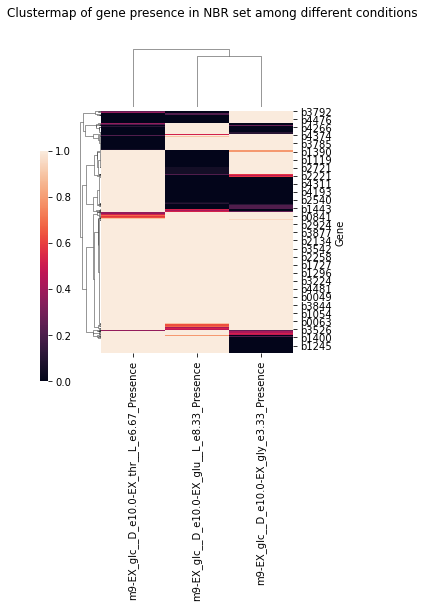

In [ ]:
at_least_one_with_one_nbr_df = nbr_final_df[(nbr_final_df[nbr_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_nbr_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))

g.fig.suptitle("Clustermap of gene presence in NBR set among different conditions", y=1.05)
fig_name = 'nbr_core_genes_clustering.svg'
fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
fig.write_image(fig_save_path)

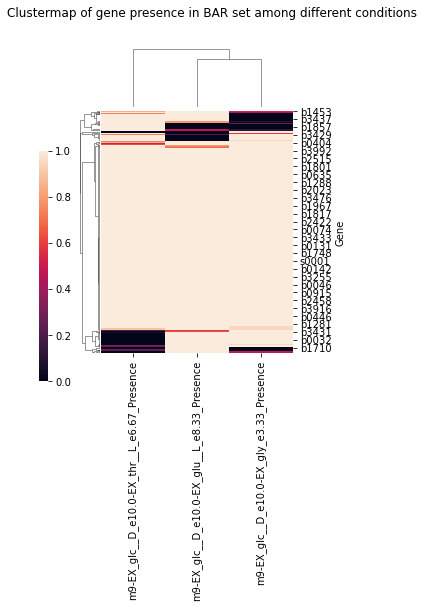

In [ ]:
at_least_one_with_one_bar_df = bar_final_df[(bar_final_df[bar_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_bar_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))
g.fig.suptitle("Clustermap of gene presence in BAR set among different conditions", y=1.05)
fig_name = 'bar_core_genes_clustering.svg'
fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
fig.write_image(fig_save_path)

In [ ]:
#HACER LO MISMO PARA LAS DEL ATP
at_least_one_with_one_atp_df = atp_final_df[(atp_final_df[atp_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_atp_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))
g.fig.suptitle("Clustermap of gene presence in BAR set among different conditions", y=1.05)

#### 5.5 Check if the functional class composition of always present genes is maintained with respect to the previous composion analysis

In [ ]:
#hay que editarlo para que acepte tambien los del atp

In [ ]:
all_with_one_nbr_df = nbr_final_df[(nbr_final_df[nbr_final_df.columns]==1.0).all(axis=1)]
all_with_one_bar_df = bar_final_df[(bar_final_df[bar_final_df.columns]==1.0).all(axis=1)]
genes_for_composition_analysis = {'BAR' : all_with_one_bar_df.index.tolist(),
                                  'NBR' : all_with_one_nbr_df.index.tolist()}

gene_function_composition = get_functional_class_composition(functional_data, imodulon_function, genes_for_composition_analysis)


In [ ]:
with pd.ExcelWriter('functional_composition_of_core_genes.xlsx') as writer:
    for fc in list(gene_function_composition.keys()):
        plot_df = gene_function_composition[fc]
        display(plot_df)
        plot_df.to_excel(writer, sheet_name=fc)
        max_value = max([ plot_df[column].max() for column in plot_df.columns ])

        threshold = percentile( [p for (colname,colval) in plot_df.iteritems() for p in colval.values], 60) 

        plot_df = plot_df.loc[(plot_df >= threshold).any(axis=1)]

        bar_node_trace = go.Scatter(
            x=['BAR_Set_percentage']*len(plot_df), y=plot_df.index,
            mode="markers",
            text=['Percentage: '+ str(c) for c in plot_df.BAR_Set_percentage.tolist()],
            marker=dict(
                color=px.colors.qualitative.D3[0],
                size=[2*(1/threshold)*s for s in plot_df.BAR_Set_percentage.tolist()],
                line_width=2)
            )

        nbr_node_trace = go.Scatter(
            x=['NBR_Set_percentage']*len(plot_df), y=plot_df.index,
            mode="markers",
            text=['Percentage: '+ str(c) for c in plot_df.NBR_Set_percentage.tolist()],
            marker=dict(
                color=px.colors.qualitative.D3[1],
                size=[2*(1/threshold)*s for s in plot_df.NBR_Set_percentage.tolist()],
                line_width=2)
            )

        fig = go.Figure(data=[bar_node_trace, nbr_node_trace],
            layout=go.Layout(
                title=dict(text = 'Percentage of '+fc+' functions in BARs & NBRs',
                           y = 0.95, x = 0.55),
                           titlefont_size=16,
                           showlegend=False,
                           hovermode='closest',
                           height = 1200
                          )
                       )

        fig.show()
        fig_name = '_'.join(['core_genes',fc,'composition.png'])
        fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
        fig.write_image(fig_save_path)

BAR_Set_percentage  NBR_Set_percentage
iModulon_function                                            
Prophage                         0.000000            0.000000
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Membrane Homeostasis             1.296296            1.253918
Amino Acid Metabolism            2.962963            2.194357
...                                   ...                 ...
Unknown                          0.000000            0.000000
Unknown                          0.000000            0.000000
Carbon Metabolism                0.740741            0.313480
Unknown                          0.555556            0.000000
Unknown                          0.000000            0.000000

[218 rows x 2 columns]

BAR_Set_percentage  \
Subsystem_function                                                       
Nucleotide Salvage Pathway                                    6.666667   
Tyrosine, Tryptophan, and Phenylalanine Metabolism            4.074074   
Purine and Pyrimidine Biosynthesis                            3.518519   
Arginine and Proline Metabolism                               3.148148   
Citric Acid Cycle                                             2.037037   
Cofactor and Prosthetic Group Biosynthesis                   18.703704   
Pyruvate Metabolism                                           3.518519   
Cysteine Metabolism                                           2.407407   
Alternate Carbon Metabolism                                   6.111111   
Anaplerotic Reactions                                         0.925926   
Alanine and Aspartate Metabolism                              1.481481   
Glycolysis/Gluconeogenesis                                    3.333333   
Valine, Leucine, and Isoleucine Metabolism                    2.777778   
Pentose Phosphate Pathway                                     1.851852   
Oxidative Phosphorylation                                     8.888889   
Lipopolysaccharide Biosynthesis / Recycling                   3.518519   
Membrane Lipid Metabolism                                     2.962963   
Unassigned                                                    0.925926   
Methylglyoxal Metabolism                                      0.370370   
tRNA Charging                                                 0.185185   
Threonine and Lysine Metabolism                               3.148148   
Folate Metabolism                                             0.740741   
Glycine and Serine Metabolism                                 2.037037   
Glyoxylate Metabolism                                         0.370370   
Cell Envelope Biosynthesis                                    5.000000   
Methionine Metabolism                                         2.222222   
Nitrogen Metabolism                                           0.185185   
Histidine Metabolism                                          1.666667   
Inorganic Ion Transport and Metabolism                        7.222222   
Glutamate Metabolism                                          0.740741   
Glycerophospholipid Metabolism                                1.481481   
Transport, Outer Membrane Porin                               1.296296   
Transport, Inner Membrane                                     8.888889   
Transport, Outer Membrane                                     0.925926   
Murein Recycling                                              0.000000   
Biomass and maintenance functions                             0.370370   
Murein Biosynthesis                                           1.481481   
Metabolite Repair                                             0.370370   

                                                    NBR_Set_percentage  
Subsystem_function                                                      
Nucleotide Salvage Pathway                                    5.329154  
Tyrosine, Tryptophan, and Phenylalanine Metabolism            0.313480  
Purine and Pyrimidine Biosynthesis                            0.313480  
Arginine and Proline Metabolism                               3.448276  
Citric Acid Cycle                                             0.000000  
Cofactor and Prosthetic Group Biosynthesis                    9.717868  
Pyruvate Metabolism                                           0.000000  
Cysteine Metabolism                                           3.134796  
Alternate Carbon Metabolism                                  24.137931  
Anaplerotic Reactions                                         0.313480  
Alanine and Aspartate Metabolism                              0.000000  
Glycolysis/Gluconeogenesis                                    1.567398  
Valine, Leucine, and Isoleucine Metabolism                    0.31348

In [ ]:
rf_model = from_cobrapy(cobra_model)
functional_class = 'Subsystem'
functional_class_list = functional_data[functional_class][functional_class].unique().tolist()

In [ ]:
query_set = set(all_with_one_nbr_df.index.tolist())
always_present_result = get_enrichment_result(query_set, functional_data, 
                                              rf_model, ica_data, 
                                              functional_class_list, functional_class=functional_class)

display(always_present_result)
always_present_result.to_csv('enrichment_analysis_nbr_core_genes.csv')

Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsystem enrichment
Computing Lipopolysaccharide Biosynthesis / Recycling Subsystem enrichment
Computing

Subsystem       p-Value    recall  \
8                         Alternate Carbon Metabolism  8.108524e-33  0.333333   
32                          Transport, Inner Membrane  1.530637e-27  0.271812   
34                                   Murein Recycling  1.726189e-16  0.575000   
5          Cofactor and Prosthetic Group Biosynthesis  1.149929e-05  0.168478   
7                                 Cysteine Metabolism  1.309846e-05  0.370370   
15        Lipopolysaccharide Biosynthesis / Recycling  1.850277e-05  0.254237   
31                    Transport, Outer Membrane Porin  1.069553e-04  0.625000   
3                     Arginine and Proline Metabolism  1.459267e-04  0.268293   
26                                Nitrogen Metabolism  2.870378e-04  0.368421   
0                          Nucleotide Salvage Pathway  8.269044e-04  0.173469   
24                         Cell Envelope Biosynthesis  9.907675e-04  0.206897   
14                          Oxidative Phosphorylation  1.471009e-03  0.165049   
36                                Murein Biosynthesis  1.997451e-03  0.315789   
30                     Glycerophospholipid Metabolism  7.198233e-03  0.250000   
17                                         Unassigned  4.891111e-02  0.166667   
28             Inorganic Ion Transport and Metabolism  5.118544e-02  0.129412   
11                         Glycolysis/Gluconeogenesis  1.287096e-01  0.138889   
16                          Membrane Lipid Metabolism  1.302641e-01  0.176471   
33                          Transport, Outer Membrane  1.398295e-01  0.148148   
22                      Glycine and Serine Metabolism  4.749799e-01  0.095238   
18                           Methylglyoxal Metabolism  5.420215e-01  0.100000   
9                               Anaplerotic Reactions  5.420215e-01  0.100000   
12         Valine, Leucine, and Isoleucine Metabolism  7.136159e-01  0.062500   
25                              Methionine Metabolism  7.906613e-01  0.050000   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  8.470269e-01  0.041667   
2                  Purine and Pyrimidine Biosynthesis  8.585721e-01  0.040000   
20                    Threonine and Lysine Metabolism  8.692484e-01  0.038462   
21                                  Folate Metabolism  1.000000e+00  0.000000   
35                  Biomass and maintenance functions  1.000000e+00  0.000000   
4                                   Citric Acid Cycle  1.000000e+00  0.000000   
6                                 Pyruvate Metabolism  1.000000e+00  0.000000   
29                               Glutamate Metabolism  1.000000e+00  0.000000   
27                               Histidine Metabolism  1.000000e+00  0.000000   
13                          Pentose Phosphate Pathway  1.000000e+00  0.000000   
23                              Glyoxylate Metabolism  1.000000e+00  0.000000   
19                                      tRNA Charging  1.000000e+00  0.000000   
10                   Alanine and Aspartate Metabolism  1.000000e+00  0.000000   
37                                  Metabolite Repair  1.000000e+00  0.000000   

    target_lenght  
8        0.333333  
32       0.271812  
34       0.575000  
5        0.168478  
7        0.370370  
15       0.254237  
31       0.625000  
3        0.268293  
26       0.368421  
0        0.173469  
24       0.206897  
14       0.165049  
36       0.315789  
30       0.250000  
17       0.166667  
28       0.129412  
11       0.138889  
16       0.176471  
33       0.148148  
22       0.095238  
18       0.100000  
9        0.100000  
12       0.062500  
25       0.050000  
1        0.041667  
2        0.040000  
20       0.038462  
21       0.000000  
35       0.000000  
4        0.000000  
6        0.000000  
29       0.000000  
27       0.000000  
13       0.000000  
23       0.000000  
19       0.000000  
10       0.000000  
37       0.000000

In [ ]:
enrichment_result = always_present_result.loc[always_present_result['p-Value']<0.05]

fig_1_col = px.colors.qualitative.D3
fig_2_col = px.colors.qualitative.D3[1:]

p_value_fig = px.bar(enrichment_result, x=functional_class, y='p-Value',
                 height=250, color_discrete_sequence=fig_1_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


recall_fig = px.bar(enrichment_result, x=functional_class, y='recall',
                 height=250, color_discrete_sequence=fig_2_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is essentially breaking down the Express fig into it's traces
figure1_traces = []
figure2_traces = []
for trace in range(len(p_value_fig["data"])):
    figure1_traces.append(p_value_fig["data"][trace])

for trace in range(len(recall_fig["data"])):
    figure2_traces.append(recall_fig["data"][trace])

#Create a 2x1 subplot
this_figure = make_subplots(rows=2, cols=1, vertical_spacing=0.02 )

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)

for traces in figure2_traces:
    this_figure.append_trace(traces, row=2, col=1)

this_figure.update_xaxes(visible=False, showticklabels=False)
this_figure['layout']['yaxis'].update(title='p Value')
this_figure['layout']['yaxis2'].update(title=functional_class+' recall')
this_figure['layout']['xaxis2'].update(title=functional_class, visible=True, showticklabels=True, tickangle=45)

this_figure.update_layout(
        title=dict(
            text='<b>'+functional_class+' enrichment analysis of NBR core genes</b>',
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=20,
                color='#000000'
            )
        )
    )


this_figure.update_layout(height=600, font=dict(size=10))
this_figure.show()
fig_name = 'enriched_subsystem_nbr_core.svg'
fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
this_figure.write_image(fig_save_path)

In [ ]:
#habría que repetirlo para las BAR
query_set = set(all_with_one_bar_df.index.tolist())
functional_class = 'Subsystem'
functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
always_present_result = get_enrichment_result(query_set, functional_data, 
                                              rf_model, ica_data, 
                                              functional_class_list, functional_class=functional_class)

display(always_present_result)
always_present_result.to_csv('enrichment_analysis_bar_core_genes.csv')

Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsystem enrichment
Computing Lipopolysaccharide Biosynthesis / Recycling Subsystem enrichment
Computing

Subsystem       p-Value    recall  \
5          Cofactor and Prosthetic Group Biosynthesis  3.636355e-45  0.548913   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  3.088199e-18  0.916667   
14                          Oxidative Phosphorylation  1.282810e-17  0.466019   
28             Inorganic Ion Transport and Metabolism  3.161326e-14  0.458824   
16                          Membrane Lipid Metabolism  6.029527e-14  0.941176   
12         Valine, Leucine, and Isoleucine Metabolism  4.562969e-13  0.937500   
2                  Purine and Pyrimidine Biosynthesis  6.410200e-13  0.760000   
24                         Cell Envelope Biosynthesis  2.153256e-10  0.465517   
20                    Threonine and Lysine Metabolism  5.085541e-10  0.653846   
0                          Nucleotide Salvage Pathway  7.855305e-10  0.367347   
27                               Histidine Metabolism  8.409054e-09  1.000000   
6                                 Pyruvate Metabolism  1.432983e-08  0.513514   
11                         Glycolysis/Gluconeogenesis  5.965243e-08  0.500000   
13                          Pentose Phosphate Pathway  6.520838e-07  0.714286   
25                              Methionine Metabolism  7.856737e-07  0.600000   
31                    Transport, Outer Membrane Porin  3.771947e-06  0.875000   
3                     Arginine and Proline Metabolism  3.838387e-06  0.414634   
7                                 Cysteine Metabolism  7.464287e-06  0.481481   
22                      Glycine and Serine Metabolism  1.386996e-05  0.523810   
4                                   Citric Acid Cycle  2.457975e-05  0.500000   
10                   Alanine and Aspartate Metabolism  4.759455e-05  0.615385   
15        Lipopolysaccharide Biosynthesis / Recycling  7.372452e-05  0.322034   
36                                Murein Biosynthesis  1.383184e-03  0.421053   
9                               Anaplerotic Reactions  4.809069e-03  0.500000   
30                     Glycerophospholipid Metabolism  7.533627e-03  0.333333   
35                  Biomass and maintenance functions  1.623573e-02  1.000000   
37                                  Metabolite Repair  1.623573e-02  1.000000   
29                               Glutamate Metabolism  1.943952e-02  0.444444   
21                                  Folate Metabolism  2.919315e-02  0.400000   
32                          Transport, Inner Membrane  4.660854e-02  0.161074   
23                              Glyoxylate Metabolism  8.169042e-02  0.500000   
19                                      tRNA Charging  1.275232e-01  1.000000   
33                          Transport, Outer Membrane  2.557395e-01  0.185185   
8                         Alternate Carbon Metabolism  2.640070e-01  0.142857   
18                           Methylglyoxal Metabolism  3.709085e-01  0.200000   
17                                         Unassigned  4.929936e-01  0.138889   
26                                Nitrogen Metabolism  9.255716e-01  0.052632   
34                                   Murein Recycling  1.000000e+00  0.000000   

    target_lenght  
5        0.548913  
1        0.916667  
14       0.466019  
28       0.458824  
16       0.941176  
12       0.937500  
2        0.760000  
24       0.465517  
20       0.653846  
0        0.367347  
27       1.000000  
6        0.513514  
11       0.500000  
13       0.714286  
25       0.600000  
31       0.875000  
3        0.414634  
7        0.481481  
22       0.523810  
4        0.500000  
10       0.615385  
15       0.322034  
36       0.421053  
9        0.500000  
30       0.333333  
35       1.000000  
37       1.000000  
29       0.444444  
21       0.400000  
32       0.161074  
23       0.500000  
19       1.000000  
33       0.185185  
8        0.142857  
18       0.200000  
17       0.138889  
26       0.052632  
34       0.000000

In [ ]:
enrichment_result = always_present_result.loc[always_present_result['p-Value']<0.05]

fig_1_col = px.colors.qualitative.D3
fig_2_col = px.colors.qualitative.D3[1:]

p_value_fig = px.bar(enrichment_result, x=functional_class, y='p-Value',
                 height=250, color_discrete_sequence=fig_1_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


recall_fig = px.bar(enrichment_result, x=functional_class, y='recall',
                 height=250, color_discrete_sequence=fig_2_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is essentially breaking down the Express fig into it's traces
figure1_traces = []
figure2_traces = []
for trace in range(len(p_value_fig["data"])):
    figure1_traces.append(p_value_fig["data"][trace])

for trace in range(len(recall_fig["data"])):
    figure2_traces.append(recall_fig["data"][trace])

#Create a 2x1 subplot
this_figure = make_subplots(rows=2, cols=1, vertical_spacing=0.02 )

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)

for traces in figure2_traces:
    this_figure.append_trace(traces, row=2, col=1)

this_figure.update_xaxes(visible=False, showticklabels=False)
this_figure['layout']['yaxis'].update(title='p Value')
this_figure['layout']['yaxis2'].update(title=functional_class+' recall')
this_figure['layout']['xaxis2'].update(title=functional_class, visible=True, showticklabels=True, tickangle=45)

this_figure.update_layout(
        title=dict(
            text='<b>'+functional_class+' enrichment analysis of BAR core genes</b>',
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=20,
                color='#000000'
            )
        )
    )


this_figure.update_layout(height=600, font=dict(size=10))
this_figure.show()
fig_name = 'enriched_subsystem_bar_core.svg'
fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
this_figure.write_image(fig_save_path)

In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#PRIMERO CON NBR
threshold = 0.8
with pd.ExcelWriter('NBR_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_nbr_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_nbr_df.loc[at_least_one_with_one_nbr_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition)

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_glu__L_e8.33_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsys

Subsystem       p-Value    recall  \
8                         Alternate Carbon Metabolism  2.683988e-43  0.467532   
32                          Transport, Inner Membrane  1.217602e-41  0.409396   
34                                   Murein Recycling  1.699519e-26  0.850000   
36                                Murein Biosynthesis  1.664170e-14  0.894737   
24                         Cell Envelope Biosynthesis  2.119666e-10  0.448276   
0                          Nucleotide Salvage Pathway  1.506843e-09  0.346939   
7                                 Cysteine Metabolism  4.001231e-09  0.592593   
15        Lipopolysaccharide Biosynthesis / Recycling  1.162371e-08  0.406780   
17                                         Unassigned  1.626991e-08  0.500000   
5          Cofactor and Prosthetic Group Biosynthesis  3.232632e-08  0.260870   
30                     Glycerophospholipid Metabolism  5.149718e-07  0.541667   
3                     Arginine and Proline Metabolism  6.487061e-06  0.390244   
26                                Nitrogen Metabolism  1.587658e-05  0.526316   
18                           Methylglyoxal Metabolism  3.548836e-04  0.600000   
31                    Transport, Outer Membrane Porin  9.096354e-04  0.625000   
20                    Threonine and Lysine Metabolism  1.970378e-03  0.346154   
14                          Oxidative Phosphorylation  1.514339e-02  0.194175   
22                      Glycine and Serine Metabolism  2.963940e-02  0.285714   
16                          Membrane Lipid Metabolism  4.094598e-02  0.294118   
23                              Glyoxylate Metabolism  7.040108e-02  0.500000   
25                              Methionine Metabolism  7.656823e-02  0.250000   
29                               Glutamate Metabolism  7.897172e-02  0.333333   
9                               Anaplerotic Reactions  1.033133e-01  0.300000   
33                          Transport, Outer Membrane  2.045048e-01  0.185185   
11                         Glycolysis/Gluconeogenesis  2.430328e-01  0.166667   
28             Inorganic Ion Transport and Metabolism  2.933594e-01  0.141176   
21                                  Folate Metabolism  3.322248e-01  0.200000   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  7.921465e-01  0.083333   
10                   Alanine and Aspartate Metabolism  8.037082e-01  0.076923   
12         Valine, Leucine, and Isoleucine Metabolism  8.652917e-01  0.062500   
6                                 Pyruvate Metabolism  9.427445e-01  0.054054   
2                  Purine and Pyrimidine Biosynthesis  9.565367e-01  0.040000   
27                               Histidine Metabolism  1.000000e+00  0.000000   
13                          Pentose Phosphate Pathway  1.000000e+00  0.000000   
19                                      tRNA Charging  1.000000e+00  0.000000   
4                                   Citric Acid Cycle  1.000000e+00  0.000000   
35                  Biomass and maintenance functions  1.000000e+00  0.000000   
37                                  Metabolite Repair  1.000000e+00  0.000000   

    target_lenght  
8        0.467532  
32       0.409396  
34       0.850000  
36       0.894737  
24       0.448276  
0        0.346939  
7        0.592593  
15       0.406780  
17       0.500000  
5        0.260870  
30       0.541667  
3        0.390244  
26       0.526316  
18       0.600000  
31       0.625000  
20       0.346154  
14       0.194175  
22       0.285714  
16       0.294118  
23       0.500000  
25       0.250000  
29       0.333333  
9        0.300000  
33       0.185185  
11       0.166667  
28       0.141176  
21       0.200000  
1        0.083333  
10       0.076923  
12       0.062500  
6        0.054054  
2        0.040000  
27       0.000000  
13       0.000000  
19       0.000000  
4        0.000000  
35       0.000000  
37       0.000000

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_gly_e3.33_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsystem

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Subsystem       p-Value    recall  \
8                         Alternate Carbon Metabolism  2.294992e-54  0.528139   
32                          Transport, Inner Membrane  1.716566e-42  0.422819   
24                         Cell Envelope Biosynthesis  3.326824e-15  0.551724   
34                                   Murein Recycling  7.331016e-14  0.625000   
0                          Nucleotide Salvage Pathway  1.284832e-09  0.357143   
6                                 Pyruvate Metabolism  8.051411e-09  0.513514   
15        Lipopolysaccharide Biosynthesis / Recycling  2.997600e-08  0.406780   
5          Cofactor and Prosthetic Group Biosynthesis  1.476111e-07  0.260870   
36                                Murein Biosynthesis  2.422523e-07  0.631579   
14                          Oxidative Phosphorylation  2.942793e-07  0.310680   
7                                 Cysteine Metabolism  6.837176e-07  0.518519   
26                                Nitrogen Metabolism  2.686032e-06  0.578947   
3                     Arginine and Proline Metabolism  1.205054e-05  0.390244   
31                    Transport, Outer Membrane Porin  7.673242e-05  0.750000   
30                     Glycerophospholipid Metabolism  2.896976e-04  0.416667   
16                          Membrane Lipid Metabolism  2.652670e-03  0.411765   
17                                         Unassigned  2.975022e-03  0.305556   
22                      Glycine and Serine Metabolism  3.645920e-02  0.285714   
33                          Transport, Outer Membrane  1.059914e-01  0.222222   
20                    Threonine and Lysine Metabolism  2.097310e-01  0.192308   
35                  Biomass and maintenance functions  2.313327e-01  0.500000   
28             Inorganic Ion Transport and Metabolism  2.430057e-01  0.152941   
18                           Methylglyoxal Metabolism  3.543758e-01  0.200000   
11                         Glycolysis/Gluconeogenesis  4.615782e-01  0.138889   
25                              Methionine Metabolism  7.261496e-01  0.100000   
9                               Anaplerotic Reactions  7.320147e-01  0.100000   
13                          Pentose Phosphate Pathway  8.418941e-01  0.071429   
12         Valine, Leucine, and Isoleucine Metabolism  8.785832e-01  0.062500   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  9.578287e-01  0.041667   
2                  Purine and Pyrimidine Biosynthesis  9.630560e-01  0.040000   
23                              Glyoxylate Metabolism  1.000000e+00  0.000000   
19                                      tRNA Charging  1.000000e+00  0.000000   
27                               Histidine Metabolism  1.000000e+00  0.000000   
29                               Glutamate Metabolism  1.000000e+00  0.000000   
10                   Alanine and Aspartate Metabolism  1.000000e+00  0.000000   
4                                   Citric Acid Cycle  1.000000e+00  0.000000   
21                                  Folate Metabolism  1.000000e+00  0.000000   
37                                  Metabolite Repair  1.000000e+00  0.000000   

    target_lenght  
8        0.528139  
32       0.422819  
24       0.551724  
34       0.625000  
0        0.357143  
6        0.513514  
15       0.406780  
5        0.260870  
36       0.631579  
14       0.310680  
7        0.518519  
26       0.578947  
3        0.390244  
31       0.750000  
30       0.416667  
16       0.411765  
17       0.305556  
22       0.285714  
33       0.222222  
20       0.192308  
35       0.500000  
28       0.152941  
18       0.200000  
11       0.138889  
25       0.100000  
9        0.100000  
13       0.071429  
12       0.062500  
1        0.041667  
2        0.040000  
23       0.000000  
19       0.000000  
27       0.000000  
29       0.000000  
10       0.000000  
4        0.000000  
21       0.000000  
37       0.000000

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_thr__L_e6.67_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsys

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Subsystem       p-Value    recall  \
8                         Alternate Carbon Metabolism  3.958081e-94  0.714286   
32                          Transport, Inner Membrane  5.436506e-60  0.523490   
34                                   Murein Recycling  7.548623e-27  0.900000   
26                                Nitrogen Metabolism  1.584234e-11  0.842105   
6                                 Pyruvate Metabolism  2.078831e-11  0.621622   
14                          Oxidative Phosphorylation  2.227190e-11  0.407767   
36                                Murein Biosynthesis  1.164413e-05  0.578947   
0                          Nucleotide Salvage Pathway  5.849454e-05  0.295918   
15        Lipopolysaccharide Biosynthesis / Recycling  1.066217e-04  0.338983   
31                    Transport, Outer Membrane Porin  1.789063e-04  0.750000   
24                         Cell Envelope Biosynthesis  7.932954e-04  0.310345   
18                           Methylglyoxal Metabolism  1.038012e-03  0.600000   
3                     Arginine and Proline Metabolism  1.060761e-03  0.341463   
7                                 Cysteine Metabolism  2.770957e-03  0.370370   
30                     Glycerophospholipid Metabolism  4.078107e-03  0.375000   
28             Inorganic Ion Transport and Metabolism  6.896193e-03  0.247059   
11                         Glycolysis/Gluconeogenesis  9.254459e-03  0.305556   
5          Cofactor and Prosthetic Group Biosynthesis  9.962047e-03  0.206522   
23                              Glyoxylate Metabolism  1.034477e-02  0.750000   
22                      Glycine and Serine Metabolism  2.208549e-02  0.333333   
17                                         Unassigned  1.309099e-01  0.222222   
20                    Threonine and Lysine Metabolism  1.558309e-01  0.230769   
33                          Transport, Outer Membrane  1.777429e-01  0.222222   
35                  Biomass and maintenance functions  2.651025e-01  0.500000   
25                              Methionine Metabolism  3.169610e-01  0.200000   
16                          Membrane Lipid Metabolism  4.457098e-01  0.176471   
13                          Pentose Phosphate Pathway  6.147168e-01  0.142857   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  6.867987e-01  0.125000   
29                               Glutamate Metabolism  7.502655e-01  0.111111   
21                                  Folate Metabolism  7.859843e-01  0.100000   
9                               Anaplerotic Reactions  7.859843e-01  0.100000   
10                   Alanine and Aspartate Metabolism  8.653385e-01  0.076923   
2                  Purine and Pyrimidine Biosynthesis  8.908470e-01  0.080000   
12         Valine, Leucine, and Isoleucine Metabolism  9.152996e-01  0.062500   
4                                   Citric Acid Cycle  9.665264e-01  0.045455   
19                                      tRNA Charging  1.000000e+00  0.000000   
27                               Histidine Metabolism  1.000000e+00  0.000000   
37                                  Metabolite Repair  1.000000e+00  0.000000   

    target_lenght  
8        0.714286  
32       0.523490  
34       0.900000  
26       0.842105  
6        0.621622  
14       0.407767  
36       0.578947  
0        0.295918  
15       0.338983  
31       0.750000  
24       0.310345  
18       0.600000  
3        0.341463  
7        0.370370  
30       0.375000  
28       0.247059  
11       0.305556  
5        0.206522  
23       0.750000  
22       0.333333  
17       0.222222  
20       0.230769  
33       0.222222  
35       0.500000  
25       0.200000  
16       0.176471  
13       0.142857  
1        0.125000  
29       0.111111  
21       0.100000  
9        0.100000  
10       0.076923  
2        0.080000  
12       0.062500  
4        0.045455  
19       0.000000  
27       0.000000  
37       0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#AHORA CON LOS BAR
threshold = 0.8
with pd.ExcelWriter('BAR_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_bar_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_bar_df.loc[at_least_one_with_one_bar_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition) 

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_glu__L_e8.33_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsys

Subsystem       p-Value    recall  \
5          Cofactor and Prosthetic Group Biosynthesis  9.572787e-45  0.597826   
0                          Nucleotide Salvage Pathway  3.012740e-24  0.602041   
14                          Oxidative Phosphorylation  6.314820e-21  0.553398   
4                                   Citric Acid Cycle  1.855200e-16  0.954545   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  3.035979e-16  0.916667   
2                  Purine and Pyrimidine Biosynthesis  2.160905e-15  0.880000   
28             Inorganic Ion Transport and Metabolism  6.104592e-15  0.517647   
12         Valine, Leucine, and Isoleucine Metabolism  1.164083e-13  1.000000   
16                          Membrane Lipid Metabolism  1.692568e-12  0.941176   
13                          Pentose Phosphate Pathway  4.904803e-12  1.000000   
11                         Glycolysis/Gluconeogenesis  6.839458e-11  0.638889   
20                    Threonine and Lysine Metabolism  9.229852e-11  0.730769   
10                   Alanine and Aspartate Metabolism  2.291294e-09  0.923077   
24                         Cell Envelope Biosynthesis  4.736460e-09  0.482759   
22                      Glycine and Serine Metabolism  1.612226e-08  0.714286   
27                               Histidine Metabolism  5.524669e-08  1.000000   
25                              Methionine Metabolism  7.495710e-08  0.700000   
6                                 Pyruvate Metabolism  4.422517e-07  0.513514   
3                     Arginine and Proline Metabolism  6.414793e-07  0.487805   
7                                 Cysteine Metabolism  2.035721e-06  0.555556   
32                          Transport, Inner Membrane  1.478587e-05  0.248322   
31                    Transport, Outer Membrane Porin  1.579722e-05  0.875000   
15        Lipopolysaccharide Biosynthesis / Recycling  1.138457e-03  0.322034   
9                               Anaplerotic Reactions  1.742040e-03  0.600000   
36                                Murein Biosynthesis  5.331759e-03  0.421053   
8                         Alternate Carbon Metabolism  5.333788e-03  0.220779   
29                               Glutamate Metabolism  6.817818e-03  0.555556   
17                                         Unassigned  1.845405e-02  0.305556   
35                  Biomass and maintenance functions  2.460810e-02  1.000000   
37                                  Metabolite Repair  2.460810e-02  1.000000   
30                     Glycerophospholipid Metabolism  2.523334e-02  0.333333   
21                                  Folate Metabolism  5.753954e-02  0.400000   
23                              Glyoxylate Metabolism  1.186330e-01  0.500000   
19                                      tRNA Charging  1.569698e-01  1.000000   
33                          Transport, Outer Membrane  4.213156e-01  0.185185   
18                           Methylglyoxal Metabolism  4.812615e-01  0.200000   
26                                Nitrogen Metabolism  9.612988e-01  0.052632   
34                                   Murein Recycling  1.000000e+00  0.000000   

    target_lenght  
5        0.597826  
0        0.602041  
14       0.553398  
4        0.954545  
1        0.916667  
2        0.880000  
28       0.517647  
12       1.000000  
16       0.941176  
13       1.000000  
11       0.638889  
20       0.730769  
10       0.923077  
24       0.482759  
22       0.714286  
27       1.000000  
25       0.700000  
6        0.513514  
3        0.487805  
7        0.555556  
32       0.248322  
31       0.875000  
15       0.322034  
9        0.600000  
36       0.421053  
8        0.220779  
29       0.555556  
17       0.305556  
35       1.000000  
37       1.000000  
30       0.333333  
21       0.400000  
23       0.500000  
19       1.000000  
33       0.185185  
18       0.200000  
26       0.052632  
34       0.000000

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_gly_e3.33_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsystem

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Subsystem       p-Value    recall  \
5          Cofactor and Prosthetic Group Biosynthesis  2.735564e-47  0.608696   
14                          Oxidative Phosphorylation  4.526149e-22  0.563107   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  2.322260e-16  0.916667   
2                  Purine and Pyrimidine Biosynthesis  1.656437e-15  0.880000   
11                         Glycolysis/Gluconeogenesis  2.035380e-15  0.750000   
12         Valine, Leucine, and Isoleucine Metabolism  9.558508e-14  1.000000   
0                          Nucleotide Salvage Pathway  1.009042e-13  0.469388   
28             Inorganic Ion Transport and Metabolism  1.359297e-13  0.494118   
16                          Membrane Lipid Metabolism  1.392717e-12  0.941176   
13                          Pentose Phosphate Pathway  4.128982e-12  1.000000   
4                                   Citric Acid Cycle  8.667896e-12  0.818182   
20                    Threonine and Lysine Metabolism  7.408716e-11  0.730769   
24                         Cell Envelope Biosynthesis  3.566784e-09  0.482759   
25                              Methionine Metabolism  4.520857e-09  0.750000   
27                               Histidine Metabolism  4.947884e-08  1.000000   
3                     Arginine and Proline Metabolism  9.192188e-08  0.512195   
22                      Glycine and Serine Metabolism  1.645202e-07  0.666667   
6                                 Pyruvate Metabolism  3.632754e-07  0.513514   
10                   Alanine and Aspartate Metabolism  1.384353e-06  0.769231   
7                                 Cysteine Metabolism  1.735107e-06  0.555556   
32                          Transport, Inner Membrane  2.391410e-06  0.255034   
29                               Glutamate Metabolism  2.505930e-06  0.888889   
31                    Transport, Outer Membrane Porin  1.452877e-05  0.875000   
21                                  Folate Metabolism  1.634409e-04  0.700000   
15        Lipopolysaccharide Biosynthesis / Recycling  9.782770e-04  0.322034   
36                                Murein Biosynthesis  4.937136e-03  0.421053   
9                               Anaplerotic Reactions  1.128925e-02  0.500000   
23                              Glyoxylate Metabolism  1.313654e-02  0.750000   
30                     Glycerophospholipid Metabolism  2.357925e-02  0.333333   
35                  Biomass and maintenance functions  2.401560e-02  1.000000   
37                                  Metabolite Repair  2.401560e-02  1.000000   
8                         Alternate Carbon Metabolism  2.575959e-02  0.203463   
19                                      tRNA Charging  1.550701e-01  1.000000   
17                                         Unassigned  3.203471e-01  0.194444   
33                          Transport, Outer Membrane  4.103995e-01  0.185185   
18                           Methylglyoxal Metabolism  4.743880e-01  0.200000   
26                                Nitrogen Metabolism  9.596033e-01  0.052632   
34                                   Murein Recycling  9.988572e-01  0.025000   

    target_lenght  
5        0.608696  
14       0.563107  
1        0.916667  
2        0.880000  
11       0.750000  
12       1.000000  
0        0.469388  
28       0.494118  
16       0.941176  
13       1.000000  
4        0.818182  
20       0.730769  
24       0.482759  
25       0.750000  
27       1.000000  
3        0.512195  
22       0.666667  
6        0.513514  
10       0.769231  
7        0.555556  
32       0.255034  
29       0.888889  
31       0.875000  
21       0.700000  
15       0.322034  
36       0.421053  
9        0.500000  
23       0.750000  
30       0.333333  
35       1.000000  
37       1.000000  
8        0.203463  
19       1.000000  
17       0.194444  
33       0.185185  
18       0.200000  
26       0.052632  
34       0.025000

Performing enrichment analysis with m9-EX_glc__D_e10.0-EX_thr__L_e6.67_Presence condition gene set
Computing Nucleotide Salvage Pathway Subsystem enrichment
Computing Tyrosine, Tryptophan, and Phenylalanine Metabolism Subsystem enrichment
Computing Purine and Pyrimidine Biosynthesis Subsystem enrichment
Computing Arginine and Proline Metabolism Subsystem enrichment
Computing Citric Acid Cycle Subsystem enrichment
Computing Cofactor and Prosthetic Group Biosynthesis Subsystem enrichment
Computing Pyruvate Metabolism Subsystem enrichment
Computing Cysteine Metabolism Subsystem enrichment
Computing Alternate Carbon Metabolism Subsystem enrichment
Computing Anaplerotic Reactions Subsystem enrichment
Computing Alanine and Aspartate Metabolism Subsystem enrichment
Computing Glycolysis/Gluconeogenesis Subsystem enrichment
Computing Valine, Leucine, and Isoleucine Metabolism Subsystem enrichment
Computing Pentose Phosphate Pathway Subsystem enrichment
Computing Oxidative Phosphorylation Subsys

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



Subsystem       p-Value    recall  \
5          Cofactor and Prosthetic Group Biosynthesis  2.704428e-42  0.576087   
14                          Oxidative Phosphorylation  1.124513e-16  0.495146   
1   Tyrosine, Tryptophan, and Phenylalanine Metabo...  1.543589e-16  0.916667   
28             Inorganic Ion Transport and Metabolism  2.883229e-16  0.529412   
0                          Nucleotide Salvage Pathway  9.163866e-15  0.479592   
2                  Purine and Pyrimidine Biosynthesis  8.592914e-13  0.800000   
16                          Membrane Lipid Metabolism  1.034723e-12  0.941176   
13                          Pentose Phosphate Pathway  3.176303e-12  1.000000   
4                                   Citric Acid Cycle  6.258415e-12  0.818182   
12         Valine, Leucine, and Isoleucine Metabolism  6.530356e-12  0.937500   
11                         Glycolysis/Gluconeogenesis  3.571933e-11  0.638889   
20                    Threonine and Lysine Metabolism  7.292084e-10  0.692308   
24                         Cell Envelope Biosynthesis  1.222119e-08  0.465517   
29                               Glutamate Metabolism  4.182837e-08  1.000000   
27                               Histidine Metabolism  4.182837e-08  1.000000   
10                   Alanine and Aspartate Metabolism  5.483825e-08  0.846154   
6                                 Pyruvate Metabolism  2.689227e-07  0.513514   
8                         Alternate Carbon Metabolism  3.818873e-07  0.277056   
3                     Arginine and Proline Metabolism  3.840237e-07  0.487805   
25                              Methionine Metabolism  5.790204e-07  0.650000   
31                    Transport, Outer Membrane Porin  1.278883e-05  0.875000   
32                          Transport, Inner Membrane  3.396500e-05  0.238255   
7                                 Cysteine Metabolism  5.300230e-05  0.481481   
22                      Glycine and Serine Metabolism  7.645941e-05  0.523810   
21                                  Folate Metabolism  1.446922e-04  0.700000   
15        Lipopolysaccharide Biosynthesis / Recycling  7.747781e-04  0.322034   
36                                Murein Biosynthesis  4.388982e-03  0.421053   
30                     Glycerophospholipid Metabolism  6.330520e-03  0.375000   
9                               Anaplerotic Reactions  1.042472e-02  0.500000   
35                  Biomass and maintenance functions  2.314039e-02  1.000000   
37                                  Metabolite Repair  2.314039e-02  1.000000   
23                              Glyoxylate Metabolism  1.123353e-01  0.500000   
19                                      tRNA Charging  1.522204e-01  1.000000   
18                           Methylglyoxal Metabolism  1.854046e-01  0.300000   
33                          Transport, Outer Membrane  3.940182e-01  0.185185   
17                                         Unassigned  6.595916e-01  0.138889   
26                                Nitrogen Metabolism  9.569275e-01  0.052632   
34                                   Murein Recycling  1.000000e+00  0.000000   

    target_lenght  
5        0.576087  
14       0.495146  
1        0.916667  
28       0.529412  
0        0.479592  
2        0.800000  
16       0.941176  
13       1.000000  
4        0.818182  
12       0.937500  
11       0.638889  
20       0.692308  
24       0.465517  
29       1.000000  
27       1.000000  
10       0.846154  
6        0.513514  
8        0.277056  
3        0.487805  
25       0.650000  
31       0.875000  
32       0.238255  
7        0.481481  
22       0.523810  
21       0.700000  
15       0.322034  
36       0.421053  
30       0.375000  
9        0.500000  
35       1.000000  
37       1.000000  
23       0.500000  
19       1.000000  
18       0.300000  
33       0.185185  
17       0.138889  
26       0.052632  
34       0.000000

/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#AHORA CON LOS ATP
threshold = 0.8
with pd.ExcelWriter('ATP_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_atp_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_atp_df.loc[at_least_one_with_one_atp_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition) 

### 6.Locate Robustness Cycles in sets and functions

In [ ]:
cycle_df = pd.read_csv('/'.join(['data',species,'robustness_cycles.csv']))
display(cycle_df)

In [ ]:
def get_robustness_cycles_active_reactions(cycle_df, query_set, model):
    result = {c : [] for c in cycle_df.cycle.unique()}

    for rx in cycle_df.reaction_id.unique():
        rx_df = cycle_df.loc[cycle_df.reaction_id == rx]
        rx_genes =  rx_df['gene_id'].tolist()
        cycle = rx_df['cycle'].tolist()[0]
        gpr_string = model.reactions.get_by_id(rx).gpr.to_string()
        if (all([g in query_set for g in rx_genes])) or (any([g in query_set for g in rx_genes]) and 'and' not in gpr_string):
            print('%s reaction of %s is active in this set!' % (rx, cycle))
            result[cycle].append(rx)

        elif any([g in query_set for g in rx_genes]) and 'and' in gpr_string:
            print('some genes of the %s reaction, belonging to %s are present, but not all' % (rx, cycle))
            print(rx_genes)
            print(set(rx_genes).intersection(query_set))
            display()

    return { k : v for k, v in result.items() if v != []}
    

In [ ]:
nbr_set = set(all_with_one_nbr_df.index.tolist())
bar_set = set(all_with_one_bar_df.index.tolist())
print('Analysis for NBR set :')
rx_cycle_nbr = get_robustness_cycles_active_reactions(cycle_df, nbr_set, cobra_model)
print('')
print('Analysis for BAR set :')
rx_cycle_bar = get_robustness_cycles_active_reactions(cycle_df, bar_set, cobra_model)